## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5rawre' #dataset-compression
TRANSFORM = 'fft-strong_intensity' #transform-group
CHANNEL = ''

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
strong_intensity_fft_1e5rawre_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5rawre\\fft\\strong_intensity'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))
NUM_BANDS = int(10) #Change to len(group_data_map) to use all bands

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
    print(group_data_map)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


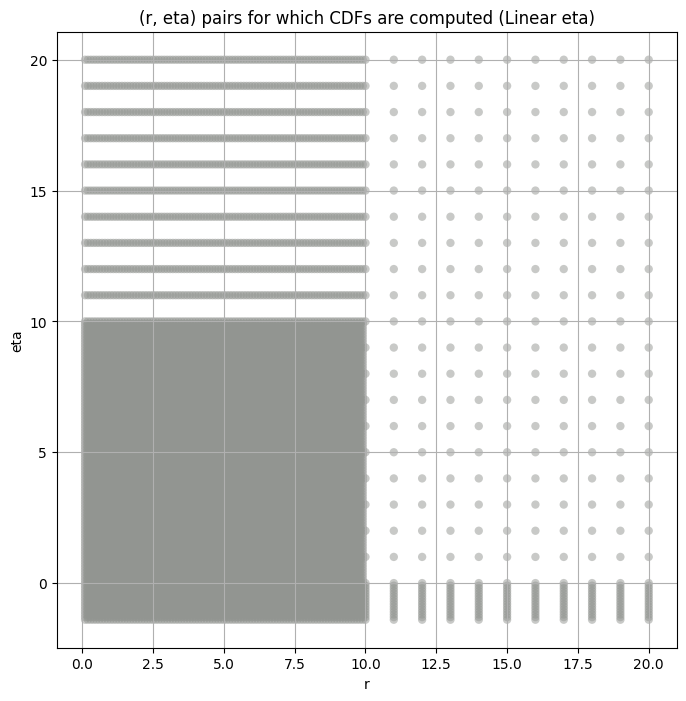

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 17


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 20


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 23


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 26


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 30


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
band,,,,,,,
2,4.046382e+14,3.362530e+14,4.864355e+14,4.984685,1.631070,7.899402,672.0
5,7.262077e+14,6.367131e+14,8.205416e+14,22.108093,18.623894,25.663944,6720.0
8,1.727584e+14,1.500757e+14,1.981757e+14,27.011762,19.469443,35.718103,12768.0
11,1.031208e+13,9.508736e+12,1.135868e+13,9.955516,2.822415,25.242559,26208.0
14,2.609331e+14,2.330198e+14,2.917817e+14,17.159369,12.404442,23.441854,52416.0
17,4.576780e+14,4.315130e+14,4.857278e+14,3.208279,2.227048,5.537420,420672.0
20,3.265137e+13,3.059805e+13,3.499262e+13,4.674552,2.595851,11.092677,841344.0
23,6.188053e+12,5.718660e+12,7.074987e+12,14.056033,2.924093,80.213660,6730752.0
26,5.004437e+11,4.612222e+11,5.520137e+11,9.796255,4.317054,34.083070,3365376.0


## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
band,,,,,,,,,,,,
2,4.046382e+14,4.046382e+14,2.561868e+14,2.087003e+14,1.728215e+14,1.462551e+14,1.075984e+14,7.849202e+13,5.746004e+13,4.269034e+13,3.049594e+13,7.941977e+12
5,7.262077e+14,7.262077e+14,5.610562e+14,4.717122e+14,4.104155e+14,3.640328e+14,2.994339e+14,2.546772e+14,2.215619e+14,1.958578e+14,1.748514e+14,1.335460e+14
8,1.727584e+14,1.727584e+14,1.430443e+14,1.294947e+14,1.189277e+14,1.096321e+14,9.435849e+13,8.266661e+13,7.354991e+13,6.647326e+13,6.055386e+13,4.863850e+13
11,1.031208e+13,1.031208e+13,9.626043e+12,9.357041e+12,9.155396e+12,8.982128e+12,8.702766e+12,8.478481e+12,8.287804e+12,8.117066e+12,7.961523e+12,7.567598e+12
14,2.609331e+14,2.609331e+14,2.473787e+14,2.389262e+14,2.322368e+14,2.264995e+14,2.166875e+14,2.084578e+14,2.011013e+14,1.946201e+14,1.888517e+14,1.742597e+14
17,4.576780e+14,4.576780e+14,4.481164e+14,4.421806e+14,4.371005e+14,4.326302e+14,4.247890e+14,4.179359e+14,4.117605e+14,4.060844e+14,4.007727e+14,3.865799e+14
20,3.265137e+13,3.265137e+13,3.170854e+13,3.120147e+13,3.078960e+13,3.043336e+13,2.982085e+13,2.929347e+13,2.882403e+13,2.839844e+13,2.800486e+13,2.696653e+13
23,6.188053e+12,6.188053e+12,5.925921e+12,5.822539e+12,5.739777e+12,5.668402e+12,5.546388e+12,5.442026e+12,5.349713e+12,5.266177e+12,5.189433e+12,4.988756e+12
26,5.004437e+11,5.004437e+11,4.796463e+11,4.696494e+11,4.617540e+11,4.550066e+11,4.435254e+11,4.337606e+11,4.251321e+11,4.173408e+11,4.101991e+11,3.916069e+11


####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.008600268834469182 404638243245545.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.03199293684719656 256186760808637.78


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.05255370058102593 208700294502583.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.07094727582656639 172821458008082.38


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.08615217140134791 146255091893575.38


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.11299287881002007 107598399638172.48


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.14653868553378968 78492020299518.31


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.17594125070090894 57460037970130.055


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.20141792165467376 42690339576368.91


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.23470856288566677 30495941605158.566


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.336078847483785 7941976947057.724
Number of samples: 1344, Without approximation : 672.0


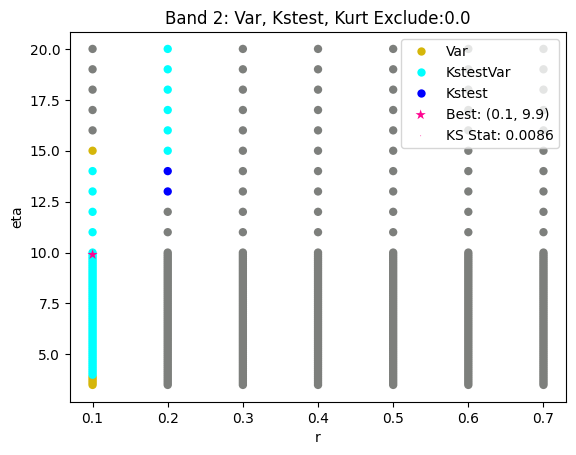

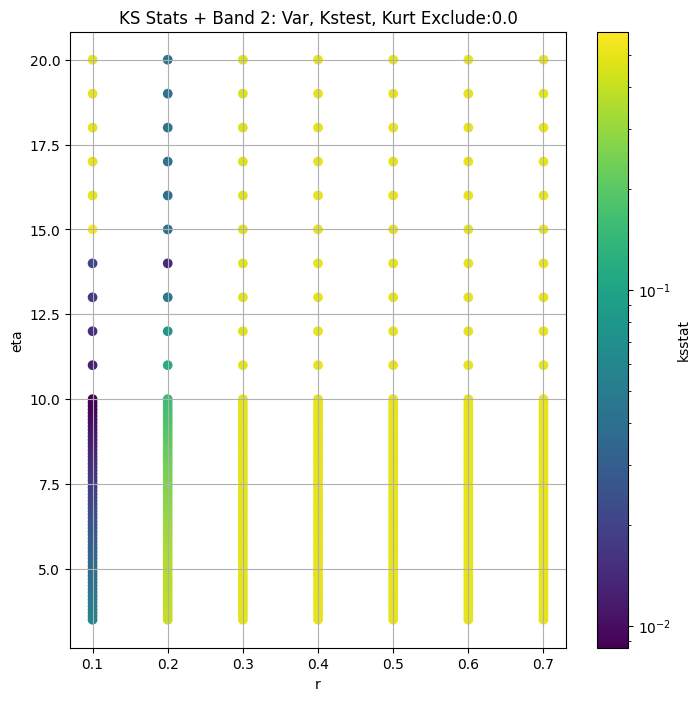

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.027584775445390175 726207661379183.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.021114407840679694 561056230913459.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.018157555437093076 471712161402702.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.015182778202684544 410415544176414.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.01331940279253134 364032834741092.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.016783537400356797 299433924404853.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.019629883885845745 254677215201675.66


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.022499449715172815 221561885923650.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.025199525730547845 195857768430772.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.028692888736316702 174851370481485.84


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.0405337651685439 133546010789318.53
Number of samples: 13440, Without approximation : 6720.0


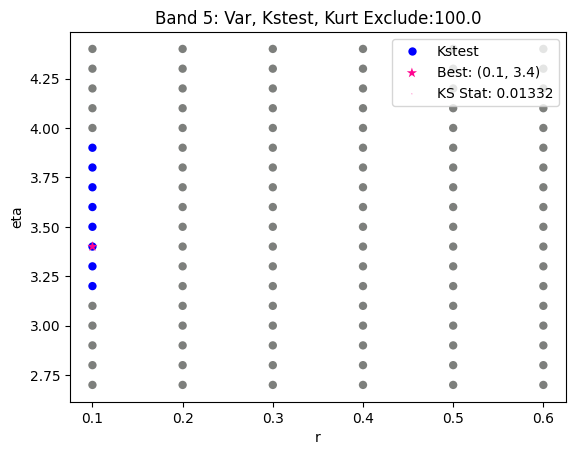

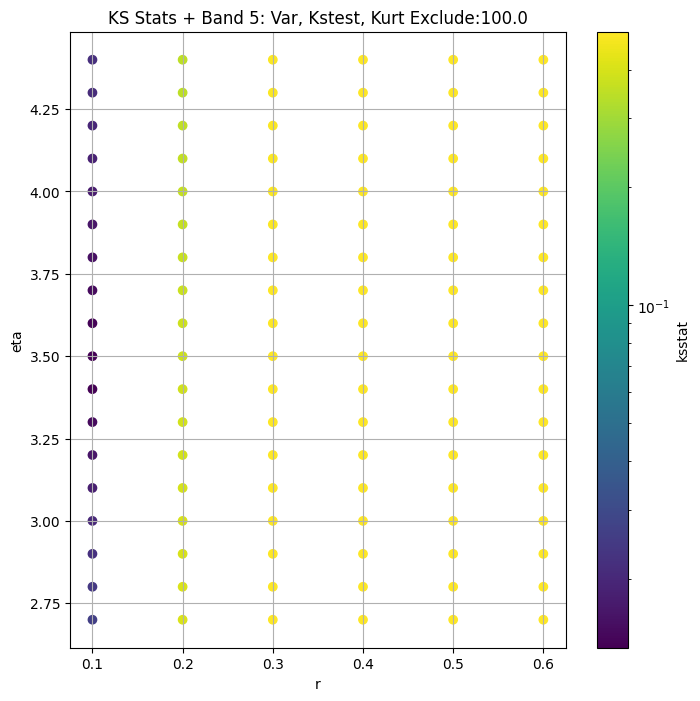

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.018998240441621128 172758414241920.12


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.018998240441621128 143044342362685.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.018998240441621128 129494696356488.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.018998240441621128 118927731571084.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.018998240441621128 109632069489708.28


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.0164472062697546 94358491822896.17


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.012796791945246189 82666606646476.02


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.013490878706399534 73549913405324.86


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.014945022130126606 66473256421382.84


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.016499900330028523 60553857465059.52


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.021301839700240466 48638503145797.266
Number of samples: 25536, Without approximation : 12768.0


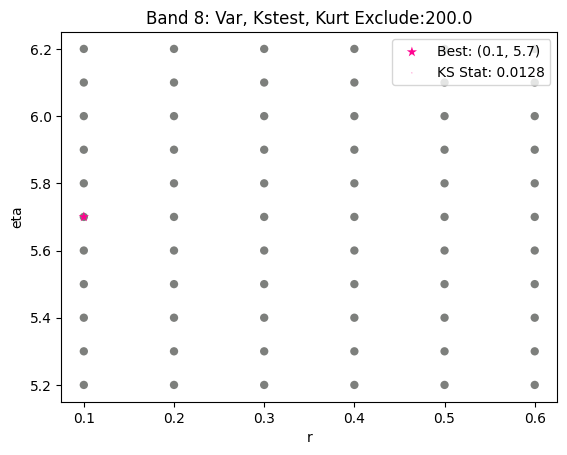

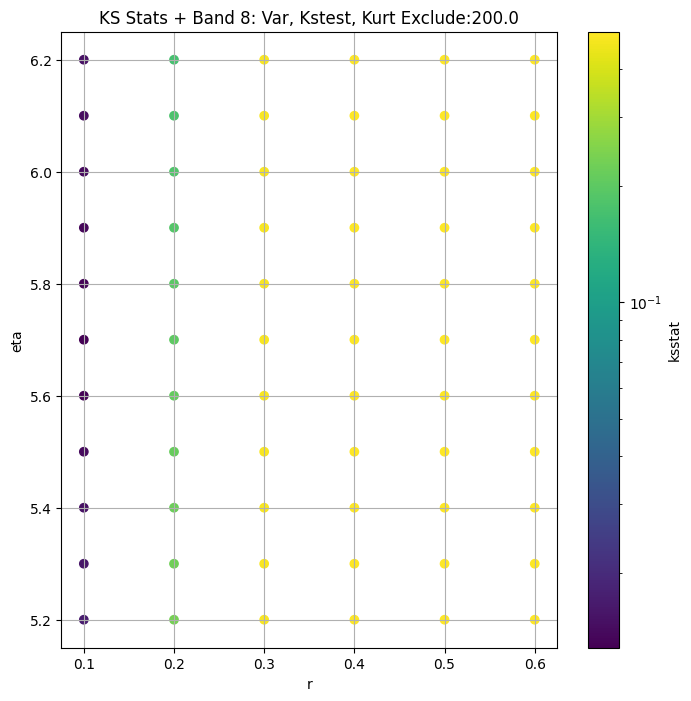

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.007173315268519741 10312080979158.943


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.00421930072339749 9626042929944.795


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.0027774778706023406 9357041019730.205


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.0025443389139859227 9155396294397.037


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.0027684614766356015 8982127956418.07


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.0038027213600940746 8702765696813.316


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.0049316738475439145 8478481496077.522


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.006163033677301755 8287803609060.082


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.007581528945744598 8117065858734.291


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.00953573429260035 7961523409172.796


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.014587706471966166 7567598325240.481
Number of samples: 52416, Without approximation : 26208.0


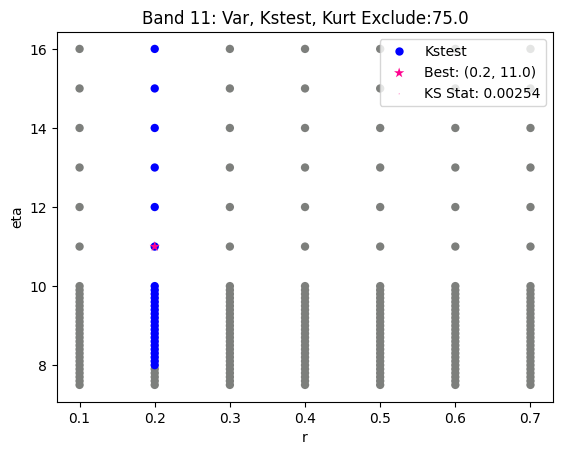

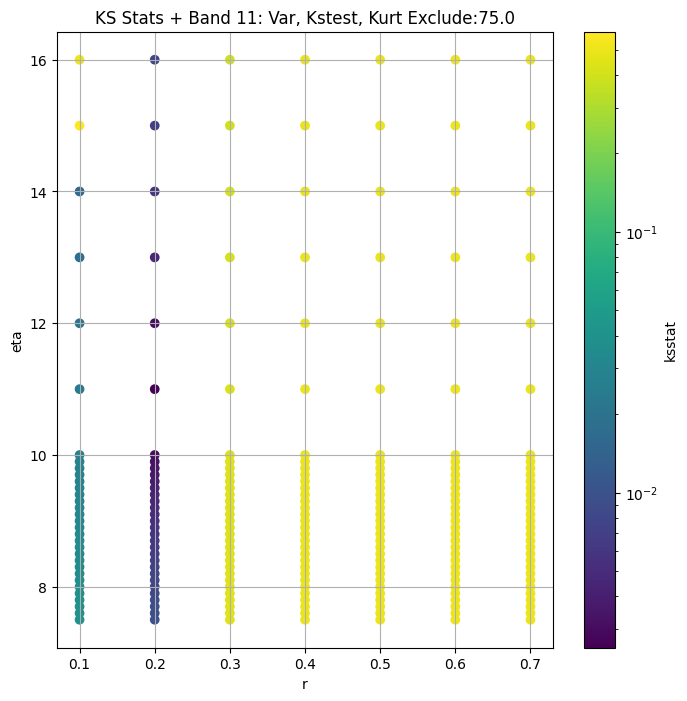

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.019397234709530406 260933144697245.03


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.02148439789115572 247378746976699.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.020832913370103512 238926245187777.28


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.02151957651896816 232236840463583.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.02250370609072186 226499505731510.28


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.02276212180278281 216687468634453.97


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.02359554461002561 208457821404263.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.025003763078735836 201101299025762.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.024358048514967284 194620111992423.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.025550897339165934 188851652686084.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.02699141998784091 174259727307264.66
Number of samples: 100000, Without approximation : 52416.0


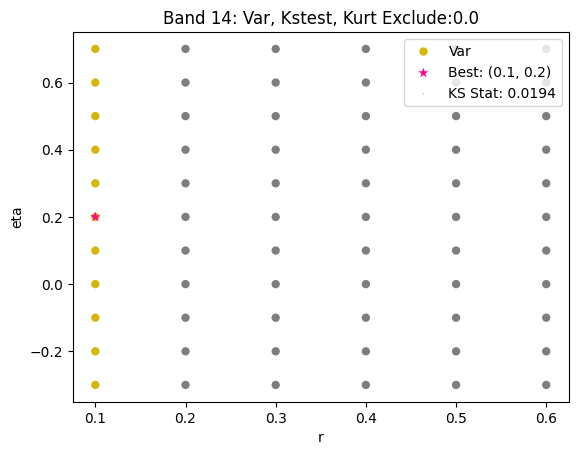

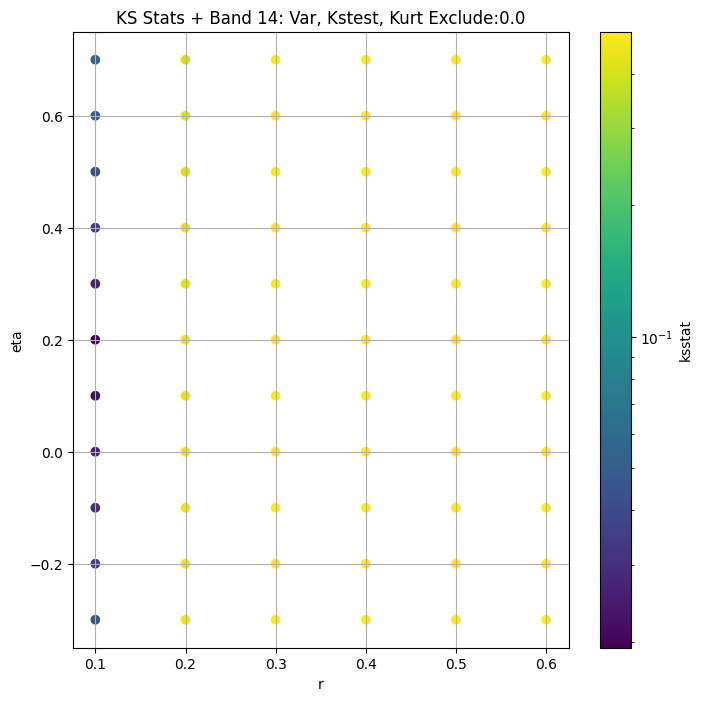

####
Band  17


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 0 0.0069610848161414385 457678001431811.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 25 0.007478141612200978 448116437027835.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 50 0.00791644535950485 442180643754749.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 75 0.008257875221098013 437100477812645.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 100 0.008582339849905016 432630156664152.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 150 0.009442886054515473 424788983704113.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 200 0.010310648347144347 417935859989625.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 250 0.010626242521250634 411760479315938.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 300 0.010993538447853335 406084385123039.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 350 0.011701402876884565 400772706449223.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 500 0.012899065944677046 386579903799355.06
Number of samples: 100000, Without approximation : 420672.0


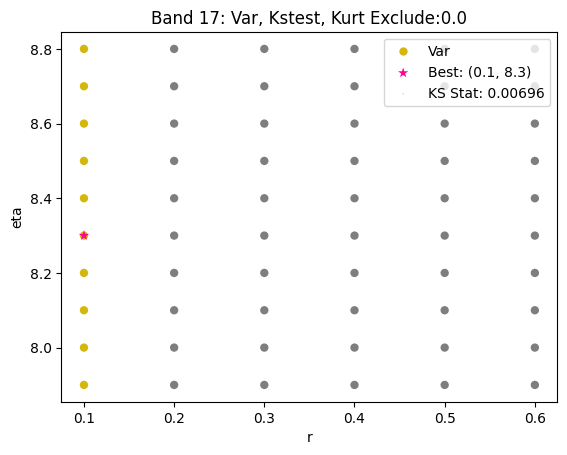

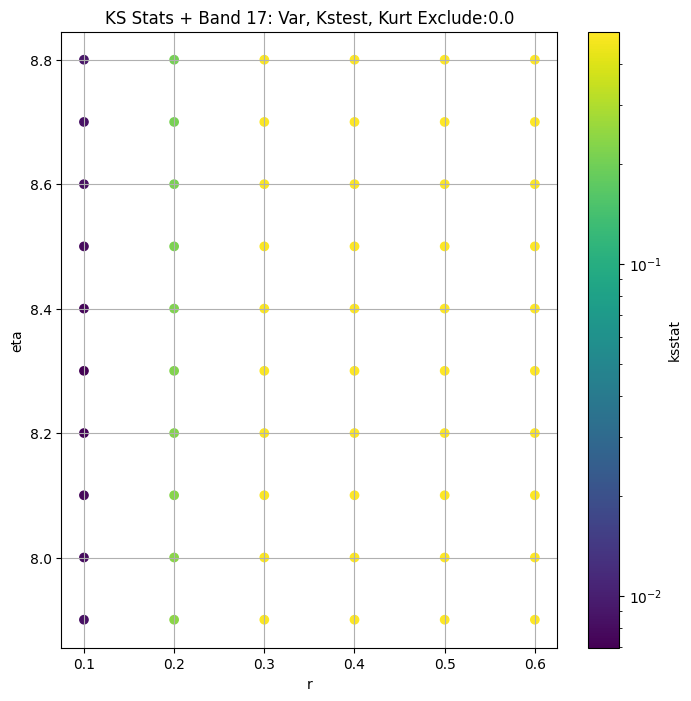

####
Band  20


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 0 0.0023641997944974236 32651372957986.49


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 25 0.0017633890936108454 31708542410574.785


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 50 0.0012655783665843322 31201471840371.617


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 75 0.001854675127040073 30789595635736.08


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 100 0.002262527900890904 30433357926343.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 150 0.003154134053687606 29820849642617.168


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 200 0.004166964183286111 29293465780166.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 250 0.004825705601198726 28824032799450.848


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 300 0.005490178371590666 28398439808160.316


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 350 0.006221587982868294 28004855833133.062


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 500 0.0083026525334189 26966534176687.32
Number of samples: 100000, Without approximation : 841344.0


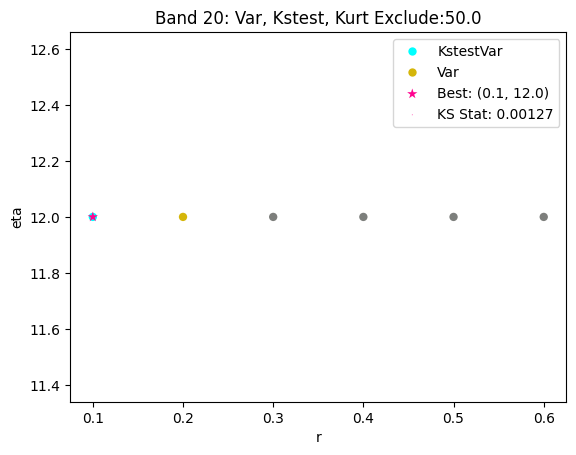

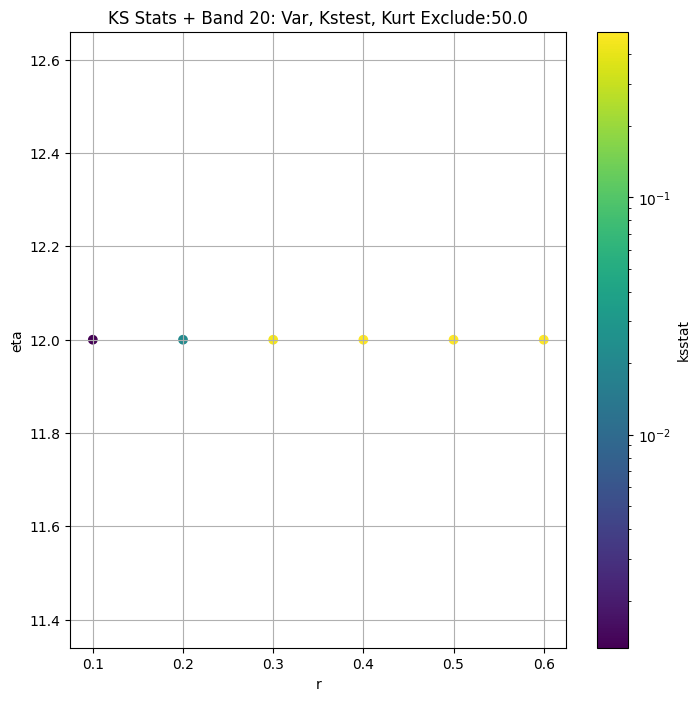

####
Band  23


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 0 0.0031725970478226895 6188052517692.42


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 25 0.0019163225167351805 5925920848529.542


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 50 0.0012820783697433669 5822539013077.352


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 75 0.0014583302084399934 5739776500805.797


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 100 0.0018400511194751144 5668402120584.084


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 150 0.0025430125856280364 5546388386601.366


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 200 0.0032977109766423526 5442026211712.4375


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 250 0.004134562560915669 5349713239080.015


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 300 0.004941351711752022 5266176783842.806


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 350 0.0057134009983691725 5189433017815.074


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 500 0.007862768204138636 4988756353662.233
Number of samples: 100000, Without approximation : 6730752.0


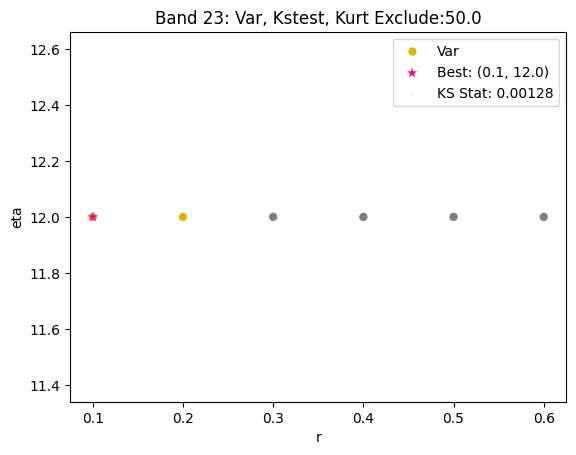

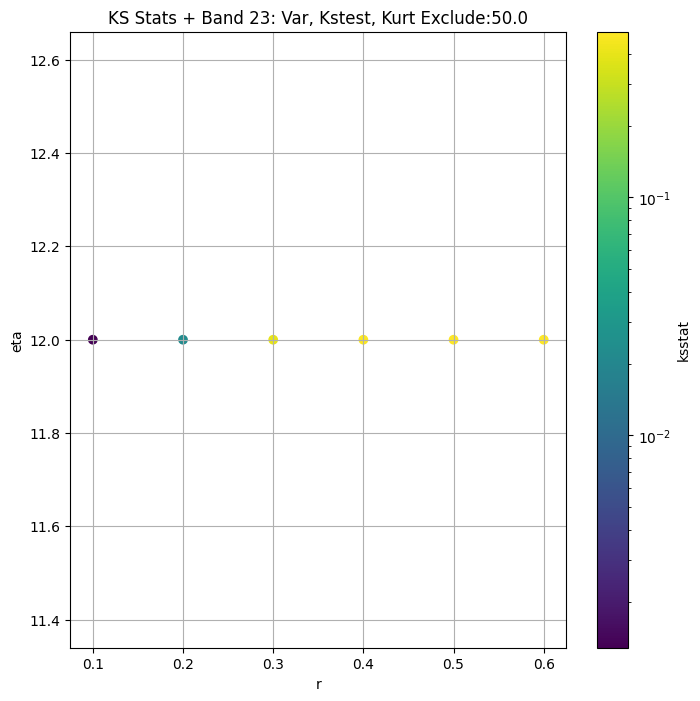

####
Band  26


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 0 0.0015599358069313674 500443663659.6297


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 25 0.001022514301023722 479646338917.86725


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 50 0.001445437468435888 469649354136.6051


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 75 0.0019691740730673896 461753998885.10736


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 100 0.0024868798680898925 455006583363.1414


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 150 0.003498339845551389 443525354182.32764


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 200 0.004404063690502499 433760574775.3368


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 250 0.005252292123648208 425132113098.5642


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 300 0.006055211930968994 417340757057.71783


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 350 0.006809170197579532 410199149192.23676


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 500 0.008945256649928193 391606918863.8497
Number of samples: 100000, Without approximation : 3365376.0


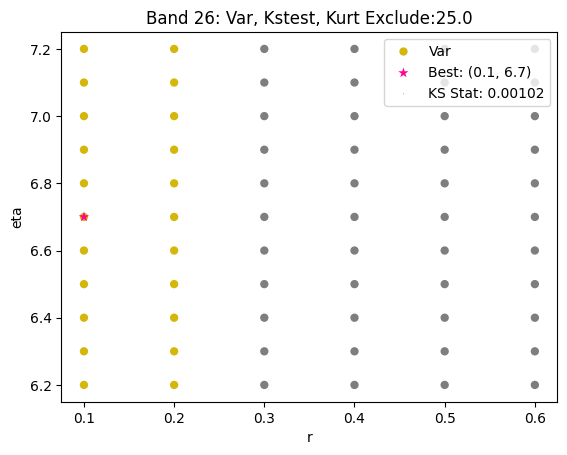

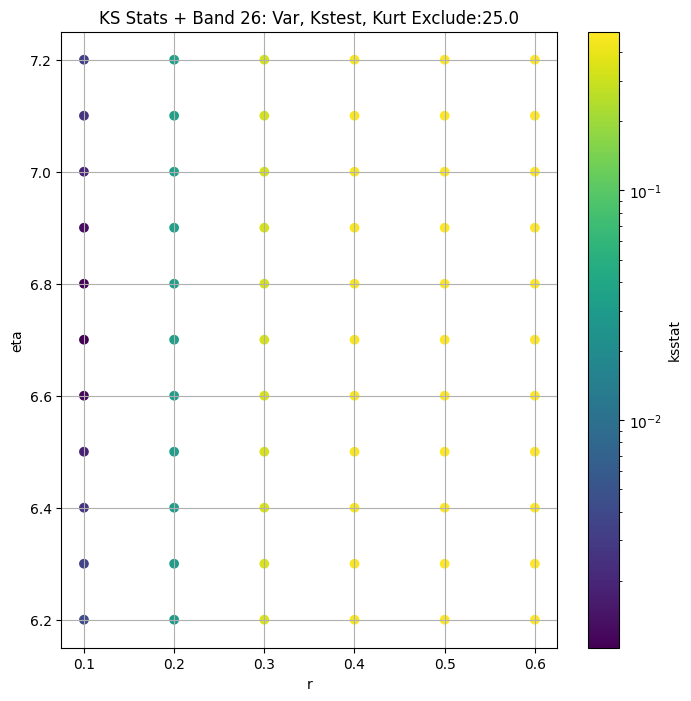

####
Band  30


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 0 0.0040632645029535785 46221654377.40374


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 25 0.0034481538966787406 44088444524.42378


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 50 0.002675906192421529 42932311743.581184


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 75 0.0031916545562737167 42003912730.34358


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 100 0.003702300439413806 41205692551.43031


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 150 0.004138795362778915 39847621222.444244


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 200 0.005009354011882881 38697900390.803856


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 250 0.005833609794843247 37686426992.178314


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 300 0.006619665757952281 36779911229.17177


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 350 0.007391194917716882 35954022888.074036


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 500 0.009548330415050266 33828476050.826115
Number of samples: 100000, Without approximation : 6730752.0


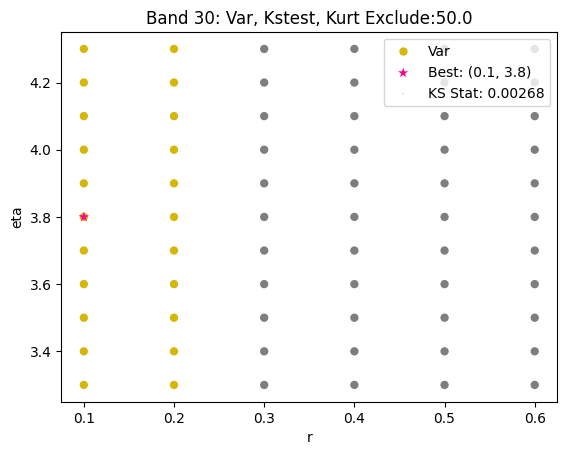

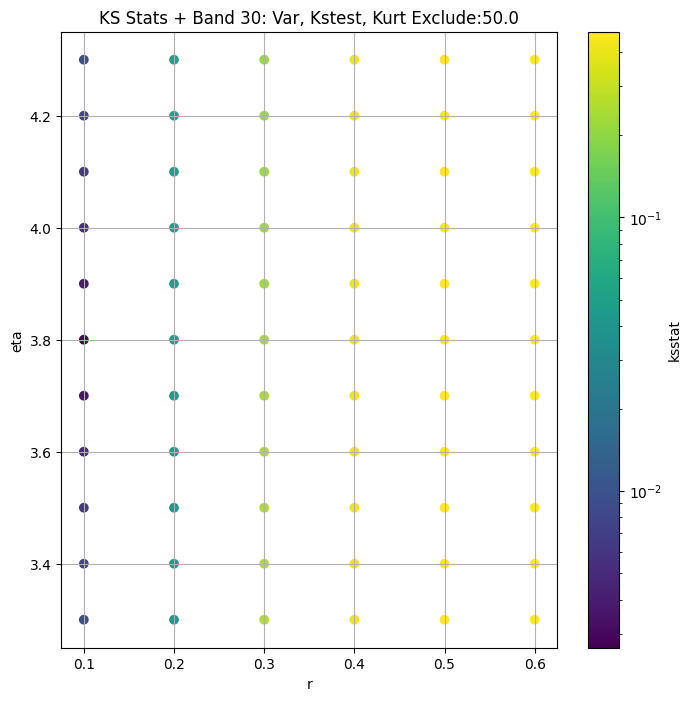

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
band,,,,,,,,,,,,,,
2,4.046382e+14,3.362530e+14,4.864355e+14,4.984685,1.631070,7.899402,672.0,0.008600,0.1,9.9,7.432927e-07,0.0,4.046382e+14,0.052135
5,7.262077e+14,6.367131e+14,8.205416e+14,22.108093,18.623894,25.663944,6720.0,0.013319,0.1,3.4,1.922551e-03,100.0,3.640328e+14,0.016542
8,1.727584e+14,1.500757e+14,1.981757e+14,27.011762,19.469443,35.718103,12768.0,0.012797,0.1,5.7,1.212776e-05,200.0,8.266661e+13,0.012006
11,1.031208e+13,9.508736e+12,1.135868e+13,9.955516,2.822415,25.242559,26208.0,0.002544,0.2,11.0,8.211089e+03,75.0,9.155396e+12,0.008383
14,2.609331e+14,2.330198e+14,2.917817e+14,17.159369,12.404442,23.441854,52416.0,0.019397,0.1,0.2,1.353723e+01,0.0,2.609331e+14,0.005929
17,4.576780e+14,4.315130e+14,4.857278e+14,3.208279,2.227048,5.537420,420672.0,0.006961,0.1,8.3,3.589448e-06,0.0,4.576780e+14,0.002094
20,3.265137e+13,3.059805e+13,3.499262e+13,4.674552,2.595851,11.092677,841344.0,0.001266,0.1,12.0,1.120351e-08,50.0,3.120147e+13,0.001480
23,6.188053e+12,5.718660e+12,7.074987e+12,14.056033,2.924093,80.213660,6730752.0,0.001282,0.1,12.0,2.090698e-09,50.0,5.822539e+12,0.000523
26,5.004437e+11,4.612222e+11,5.520137e+11,9.796255,4.317054,34.083070,3365376.0,0.001023,0.1,6.7,2.056632e-08,25.0,4.796463e+11,0.000740


In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/347 [00:00<?, ?it/s]

Finding Minimum after computing 347 CDFs
band 2, 0.0 + 100 = 100, ksstat: 0.0893313828286898, var: 146255091893575.38


  0%|          | 0/347 [00:00<?, ?it/s]

Finding Minimum after computing 347 CDFs
band 2, 0.0 + 75 = 75, ksstat: 0.07532104244074389, var: 172821458008082.38


  0%|          | 0/347 [00:00<?, ?it/s]

Finding Minimum after computing 347 CDFs
band 2, 0.0 + 50 = 50, ksstat: 0.05839861665384005, var: 208700294502583.0


  0%|          | 0/347 [00:00<?, ?it/s]

Finding Minimum after computing 347 CDFs
band 2, 0.0 + 25 = 25, ksstat: 0.038484854521737, var: 256186760808637.78


  0%|          | 0/347 [00:00<?, ?it/s]

Finding Minimum after computing 347 CDFs
band 2, 0.0 + 0 = 0, ksstat: 0.008600268834469182, var: 404638243245545.06
Number of samples: 1344, Without approximation : 672.0


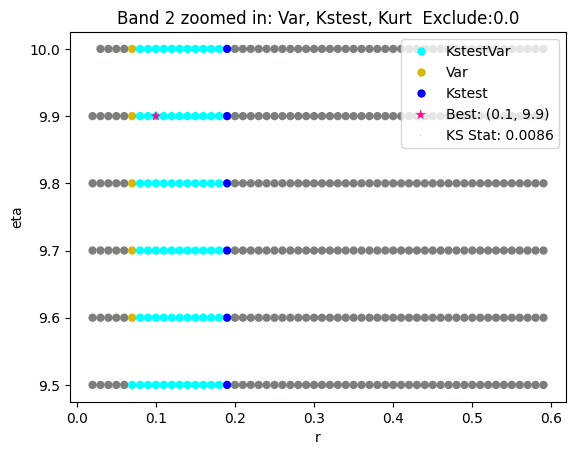

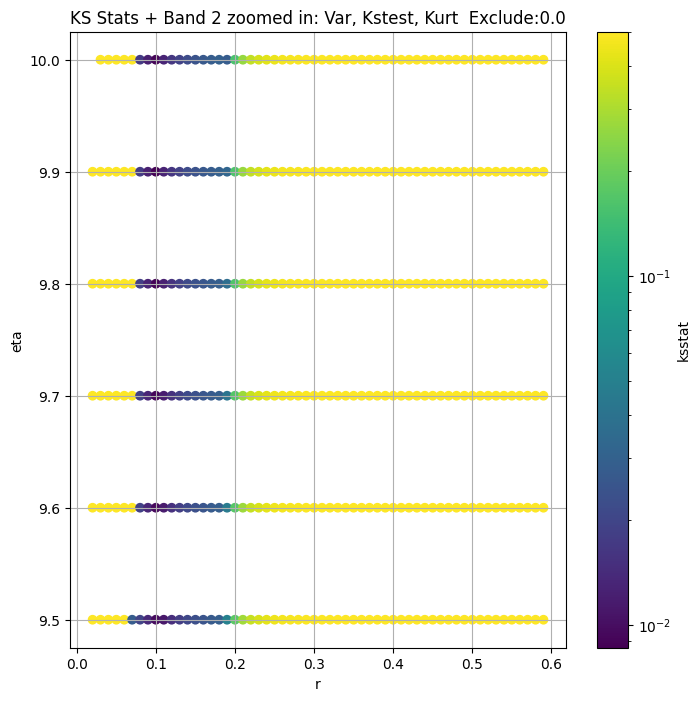

Band 5


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + 100 = 200, ksstat: 0.01961826247350451, var: 254677215201675.66


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + 75 = 175, ksstat: 0.01825737006734074, var: 275066165176584.72


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + 50 = 150, ksstat: 0.016746851448039952, var: 299433924404853.6


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + 25 = 125, ksstat: 0.015156410433750156, var: 328890379178293.94


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + 0 = 100, ksstat: 0.013312247193186945, var: 364032834741092.7


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + -25 = 75, ksstat: 0.014766548018166084, var: 410415544176414.06


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + -50 = 50, ksstat: 0.017693573314588526, var: 471712161402702.3


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + -75 = 25, ksstat: 0.01842796701731697, var: 561056230913459.0


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + -100 = 0, ksstat: 0.01842796701731697, var: 726207661379183.4
Number of samples: 13440, Without approximation : 6720.0


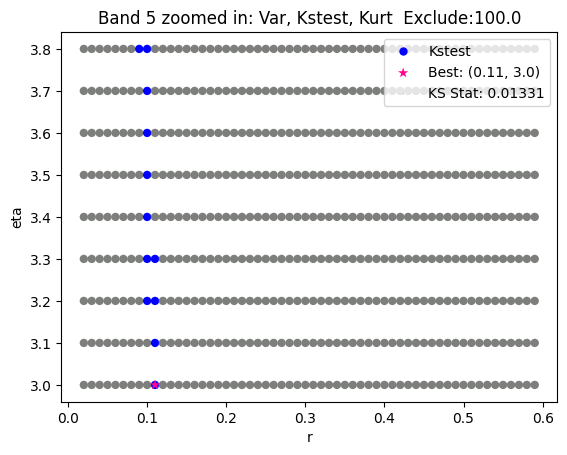

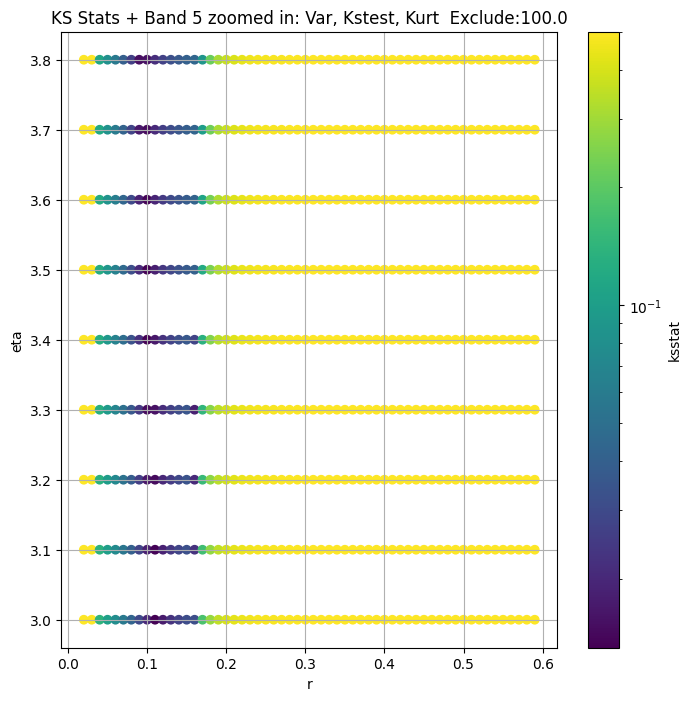

Band 8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + 100 = 300, ksstat: 0.014952662625764047, var: 66473256421382.84


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + 75 = 275, ksstat: 0.014175642420886253, var: 69840835441403.695


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + 50 = 250, ksstat: 0.013506447448488803, var: 73549913405324.86


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + 25 = 225, ksstat: 0.012764765525807749, var: 77835703524406.72


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + 0 = 200, ksstat: 0.012796791945246189, var: 82666606646476.02


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + -25 = 175, ksstat: 0.014509425178140245, var: 88144727017419.61


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + -50 = 150, ksstat: 0.0160696686284853, var: 94358491822896.17


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + -75 = 125, ksstat: 0.01824925565094926, var: 101515674272873.44


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + -100 = 100, ksstat: 0.01983791721319525, var: 109632069489708.28
Number of samples: 25536, Without approximation : 12768.0


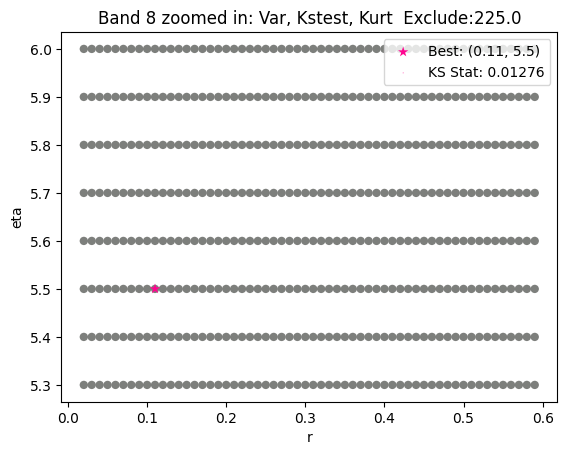

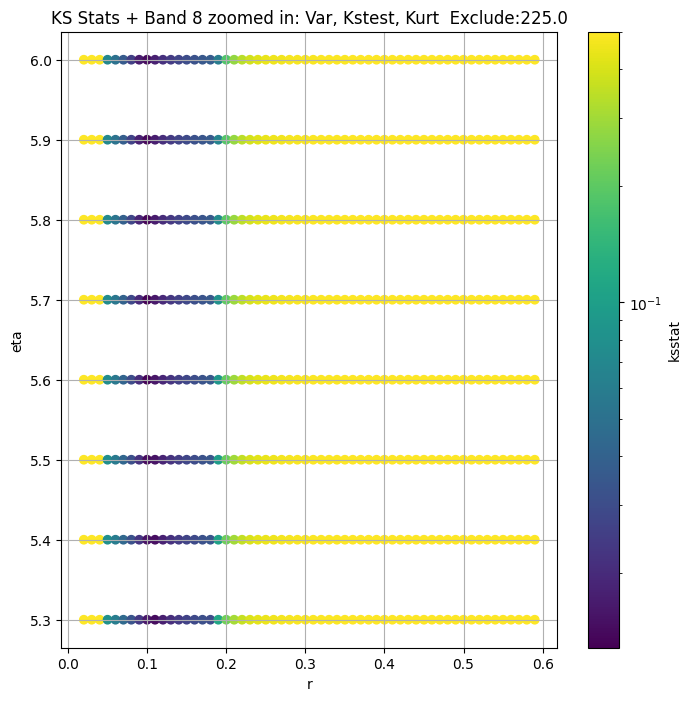

Band 11


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 75.0 + 100 = 175, ksstat: 0.005810066654353907, var: 8585306698357.969


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 75.0 + 75 = 150, ksstat: 0.004306400629840668, var: 8702765696813.316


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 75.0 + 50 = 125, ksstat: 0.00331592287246929, var: 8832324833719.47


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 75.0 + 25 = 100, ksstat: 0.0027684614766356015, var: 8982127956418.07


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 75.0 + 0 = 75, ksstat: 0.002414320067729483, var: 9155396294397.037


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 75.0 + -25 = 50, ksstat: 0.0028487047901462614, var: 9357041019730.205


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 75.0 + -50 = 25, ksstat: 0.0042608733179525515, var: 9626042929944.795


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 75.0 + -75 = 0, ksstat: 0.007530796192848799, var: 10312080979158.943
Number of samples: 52416, Without approximation : 26208.0


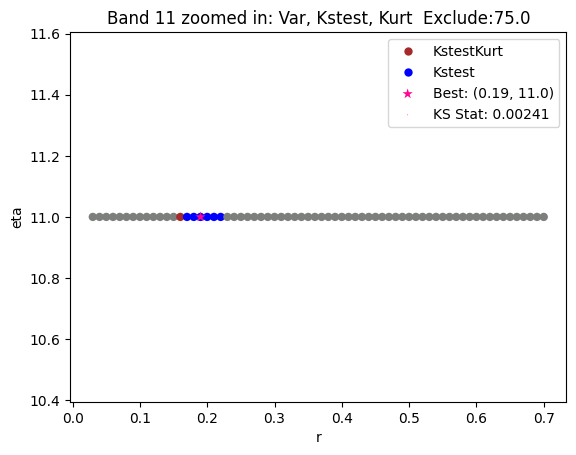

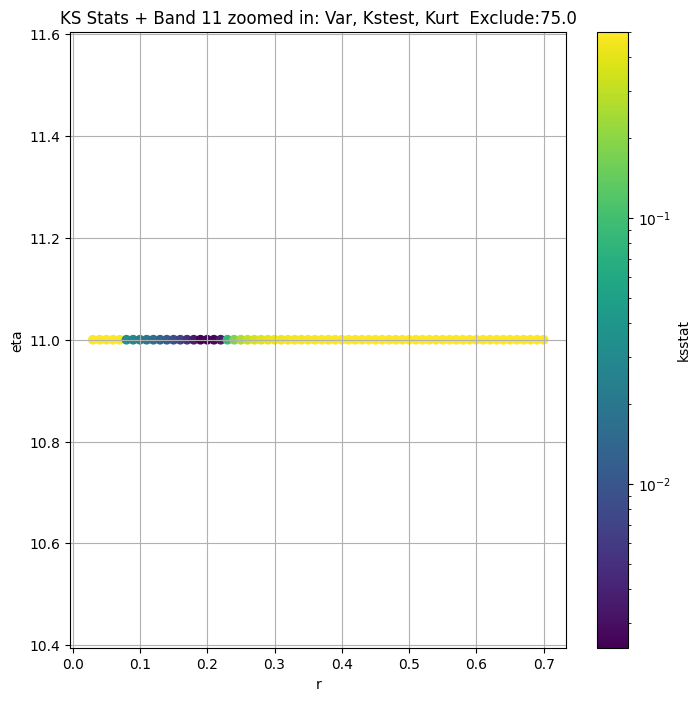

Band 14


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 14, 0.0 + 100 = 100, ksstat: 0.020563459616631155, var: 226499505731510.28


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 14, 0.0 + 75 = 75, ksstat: 0.021431829232060454, var: 232236840463583.75


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 14, 0.0 + 50 = 50, ksstat: 0.02030741744369796, var: 238926245187777.28


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 14, 0.0 + 25 = 25, ksstat: 0.019855516782159577, var: 247378746976699.4


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 14, 0.0 + 0 = 0, ksstat: 0.01910168057807815, var: 260933144697245.03
Number of samples: 100000, Without approximation : 52416.0


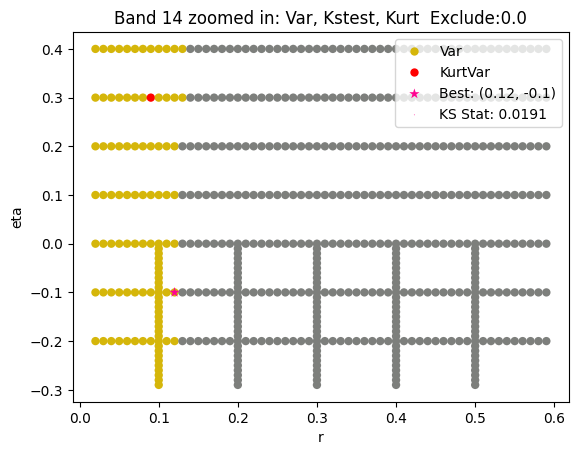

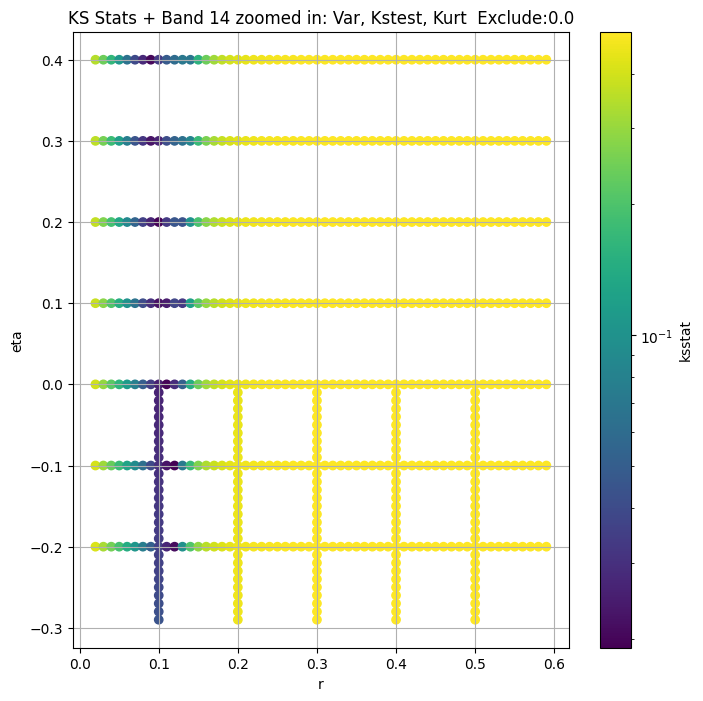

Band 17


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 100 = 100, ksstat: 0.008457576515232088, var: 432630156664152.2


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 75 = 75, ksstat: 0.008172199651621512, var: 437100477812645.5


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 50 = 50, ksstat: 0.00786369241239726, var: 442180643754749.3


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 25 = 25, ksstat: 0.007478141612200978, var: 448116437027835.1


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 0 = 0, ksstat: 0.0069610848161414385, var: 457678001431811.44
Number of samples: 100000, Without approximation : 420672.0


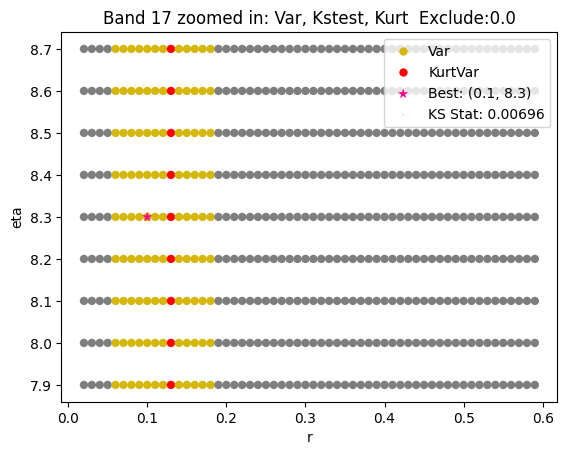

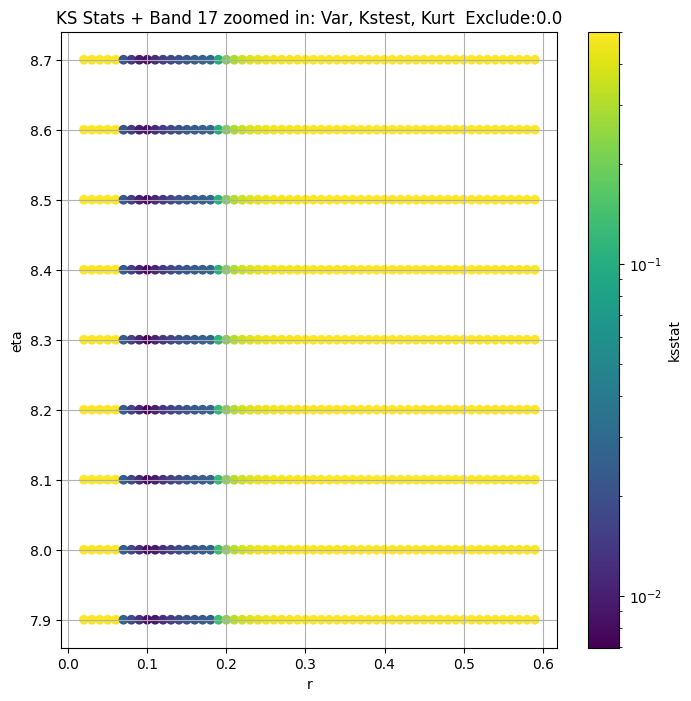

Band 20


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 50.0 + 100 = 150, ksstat: 0.0031648774410170874, var: 29820849642617.168


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 50.0 + 75 = 125, ksstat: 0.002678232174851844, var: 30114189433057.58


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 50.0 + 50 = 100, ksstat: 0.00232425069802104, var: 30433357926343.2


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 50.0 + 25 = 75, ksstat: 0.001854675127040073, var: 30789595635736.08


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 50.0 + 0 = 50, ksstat: 0.0012655783665843322, var: 31201471840371.617


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 50.0 + -25 = 25, ksstat: 0.0017633890936108454, var: 31708542410574.785


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 50.0 + -50 = 0, ksstat: 0.0017742855443474426, var: 32651372957986.49
Number of samples: 100000, Without approximation : 841344.0


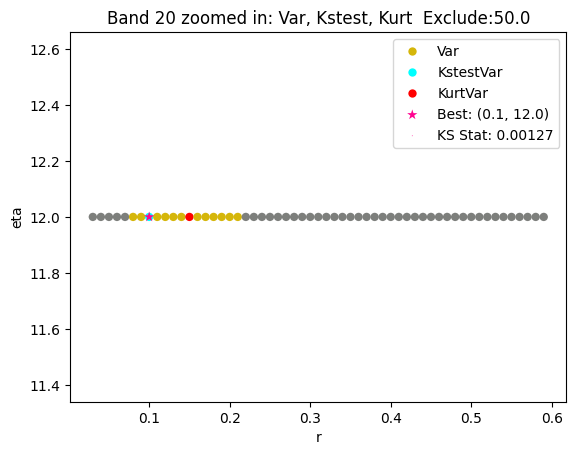

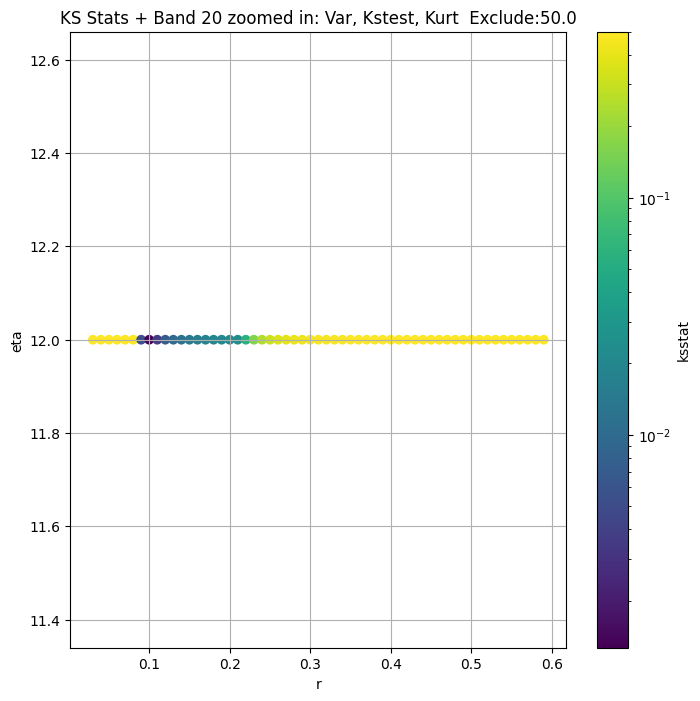

Band 23


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + 100 = 150, ksstat: 0.002733919278422526, var: 5546388386601.366


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + 75 = 125, ksstat: 0.00237857964612229, var: 5604644142784.348


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + 50 = 100, ksstat: 0.0020725587468172837, var: 5668402120584.084


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + 25 = 75, ksstat: 0.0014583302084399934, var: 5739776500805.797


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + 0 = 50, ksstat: 0.0012820783697433669, var: 5822539013077.352


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + -25 = 25, ksstat: 0.0030414197783198427, var: 5925920848529.542


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + -50 = 0, ksstat: 0.004377366911256564, var: 6188052517692.42
Number of samples: 100000, Without approximation : 6730752.0


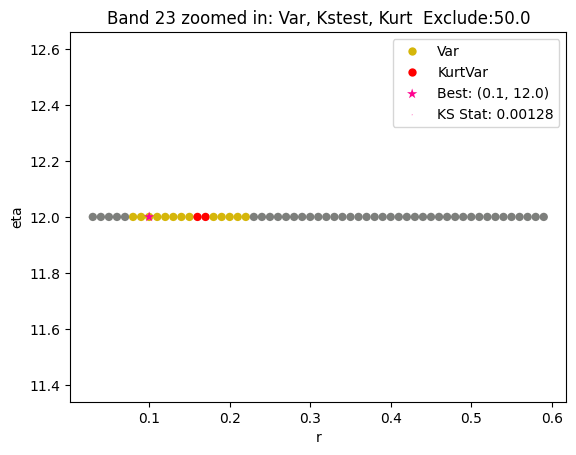

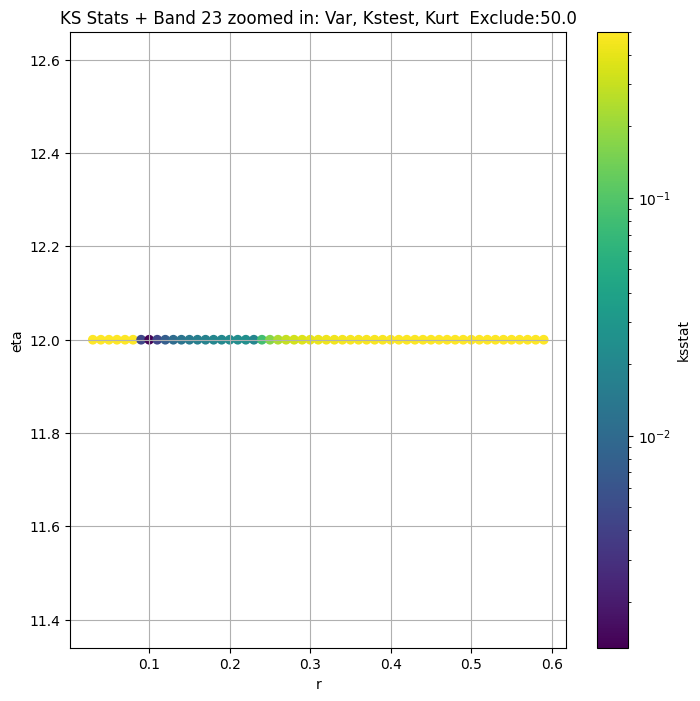

Band 26


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + 100 = 125, ksstat: 0.003295356686410164, var: 449001175276.20483


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + 75 = 100, ksstat: 0.0028166556600822887, var: 455006583363.1414


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + 50 = 75, ksstat: 0.002256449216692897, var: 461753998885.10736


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + 25 = 50, ksstat: 0.0016751865716786267, var: 469649354136.6051


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + 0 = 25, ksstat: 0.001022514301023722, var: 479646338917.86725


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + -25 = 0, ksstat: 0.001513340684141773, var: 500443663659.6297
Number of samples: 100000, Without approximation : 3365376.0


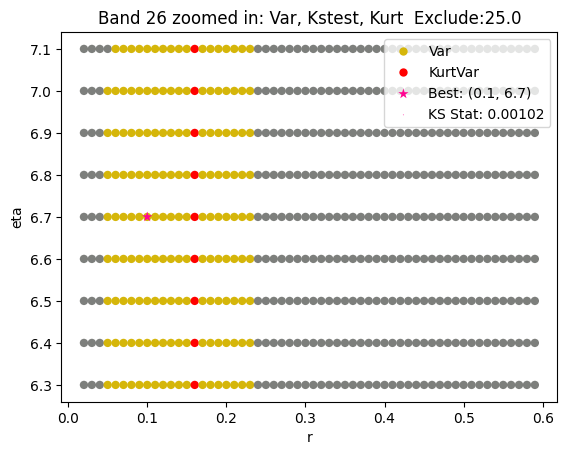

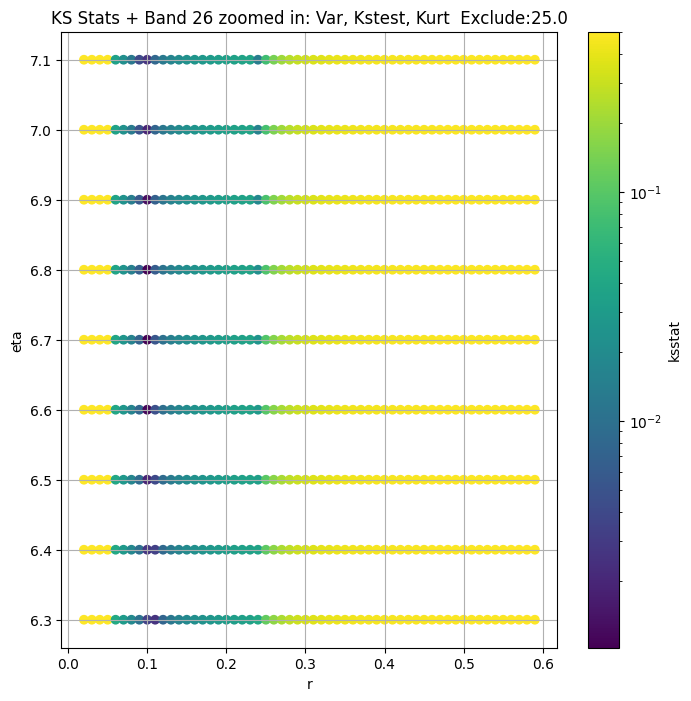

Band 30


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 50.0 + 100 = 150, ksstat: 0.0045296400410631335, var: 39847621222.444244


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 50.0 + 75 = 125, ksstat: 0.004134366222652546, var: 40494195668.503044


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 50.0 + 50 = 100, ksstat: 0.0036329618655054144, var: 41205692551.43031


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 50.0 + 25 = 75, ksstat: 0.0031239570171603392, var: 42003912730.34358


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 50.0 + 0 = 50, ksstat: 0.002675906192421529, var: 42932311743.581184


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 50.0 + -25 = 25, ksstat: 0.0032183388334361407, var: 44088444524.42378


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 50.0 + -50 = 0, ksstat: 0.0040632645029535785, var: 46221654377.40374
Number of samples: 100000, Without approximation : 6730752.0


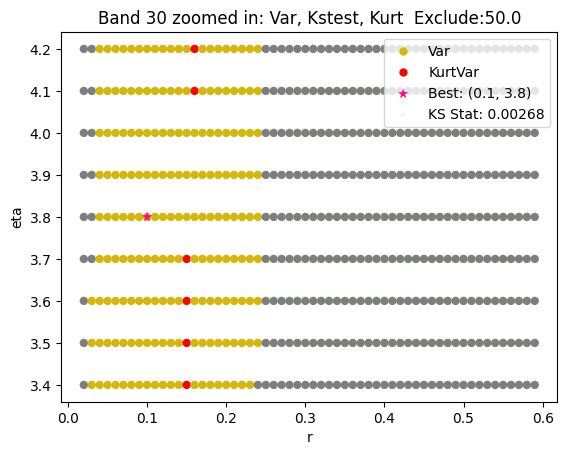

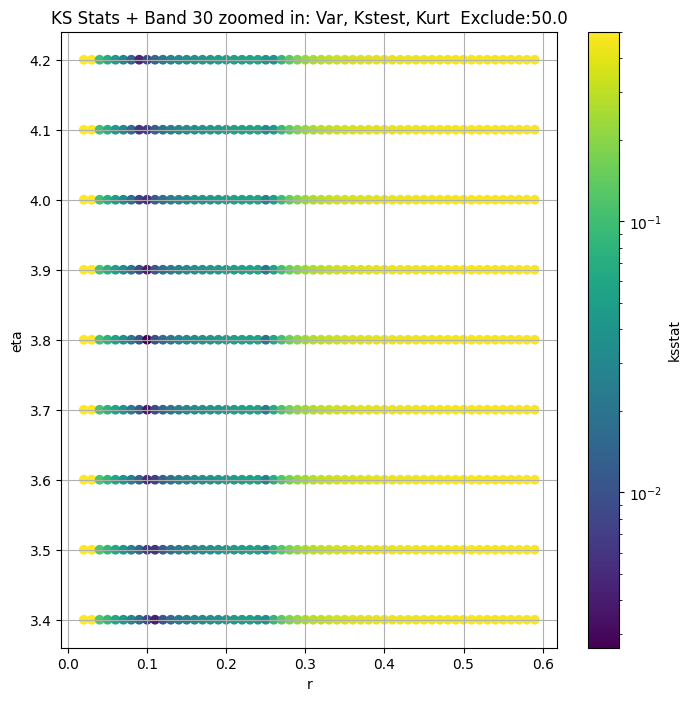

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff,n_pval_0.05
band,,,,,,,,,,,,,,,,,,,,
2,4.046382e+14,3.362530e+14,4.864355e+14,4.984685,1.631070,7.899402,672.0,0.008600,0.1,9.9,7.432927e-07,0.0,4.046382e+14,0.052135,0.008600,0.10,9.9,7.432927e-07,0.0,25831
5,7.262077e+14,6.367131e+14,8.205416e+14,22.108093,18.623894,25.663944,6720.0,0.013319,0.1,3.4,1.922551e-03,100.0,3.640328e+14,0.016542,0.013312,0.11,3.0,3.488123e-01,100.0,10080
8,1.727584e+14,1.500757e+14,1.981757e+14,27.011762,19.469443,35.718103,12768.0,0.012797,0.1,5.7,1.212776e-05,200.0,7.783570e+13,0.012006,0.012765,0.11,5.5,1.792504e-03,225.0,10773
11,1.031208e+13,9.508736e+12,1.135868e+13,9.955516,2.822415,25.242559,26208.0,0.002544,0.2,11.0,8.211089e+03,75.0,9.155396e+12,0.008383,0.002414,0.19,11.0,2.089778e+03,75.0,318781
14,2.609331e+14,2.330198e+14,2.917817e+14,17.159369,12.404442,23.441854,52416.0,0.019397,0.1,0.2,1.353723e+01,0.0,2.609331e+14,0.005929,0.019102,0.12,-0.1,3.811502e+04,0.0,4914
17,4.576780e+14,4.315130e+14,4.857278e+14,3.208279,2.227048,5.537420,420672.0,0.006961,0.1,8.3,3.589448e-06,0.0,4.576780e+14,0.002094,0.006961,0.10,8.3,3.589448e-06,0.0,39438
20,3.265137e+13,3.059805e+13,3.499262e+13,4.674552,2.595851,11.092677,841344.0,0.001266,0.1,12.0,1.120351e-08,50.0,3.120147e+13,0.001480,0.001266,0.10,12.0,1.120351e-08,50.0,1197928
23,6.188053e+12,5.718660e+12,7.074987e+12,14.056033,2.924093,80.213660,6730752.0,0.001282,0.1,12.0,2.090698e-09,50.0,5.822539e+12,0.000523,0.001282,0.10,12.0,2.090698e-09,50.0,1137094
26,5.004437e+11,4.612222e+11,5.520137e+11,9.796255,4.317054,34.083070,3365376.0,0.001023,0.1,6.7,2.056632e-08,25.0,4.796463e+11,0.000740,0.001023,0.10,6.7,2.056632e-08,25.0,1682688


In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

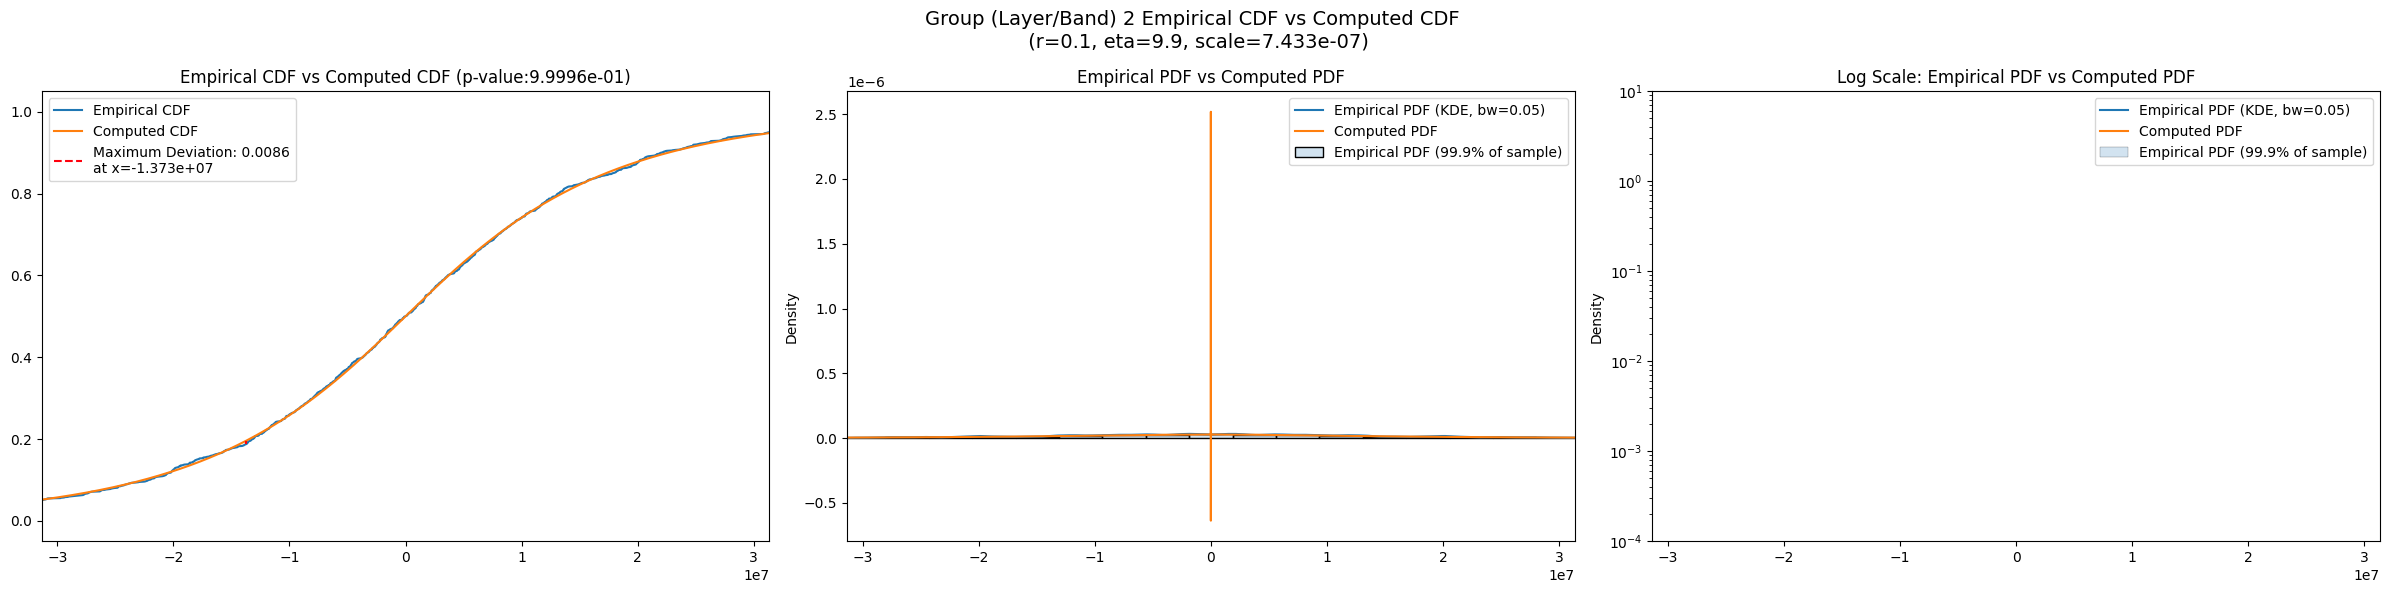

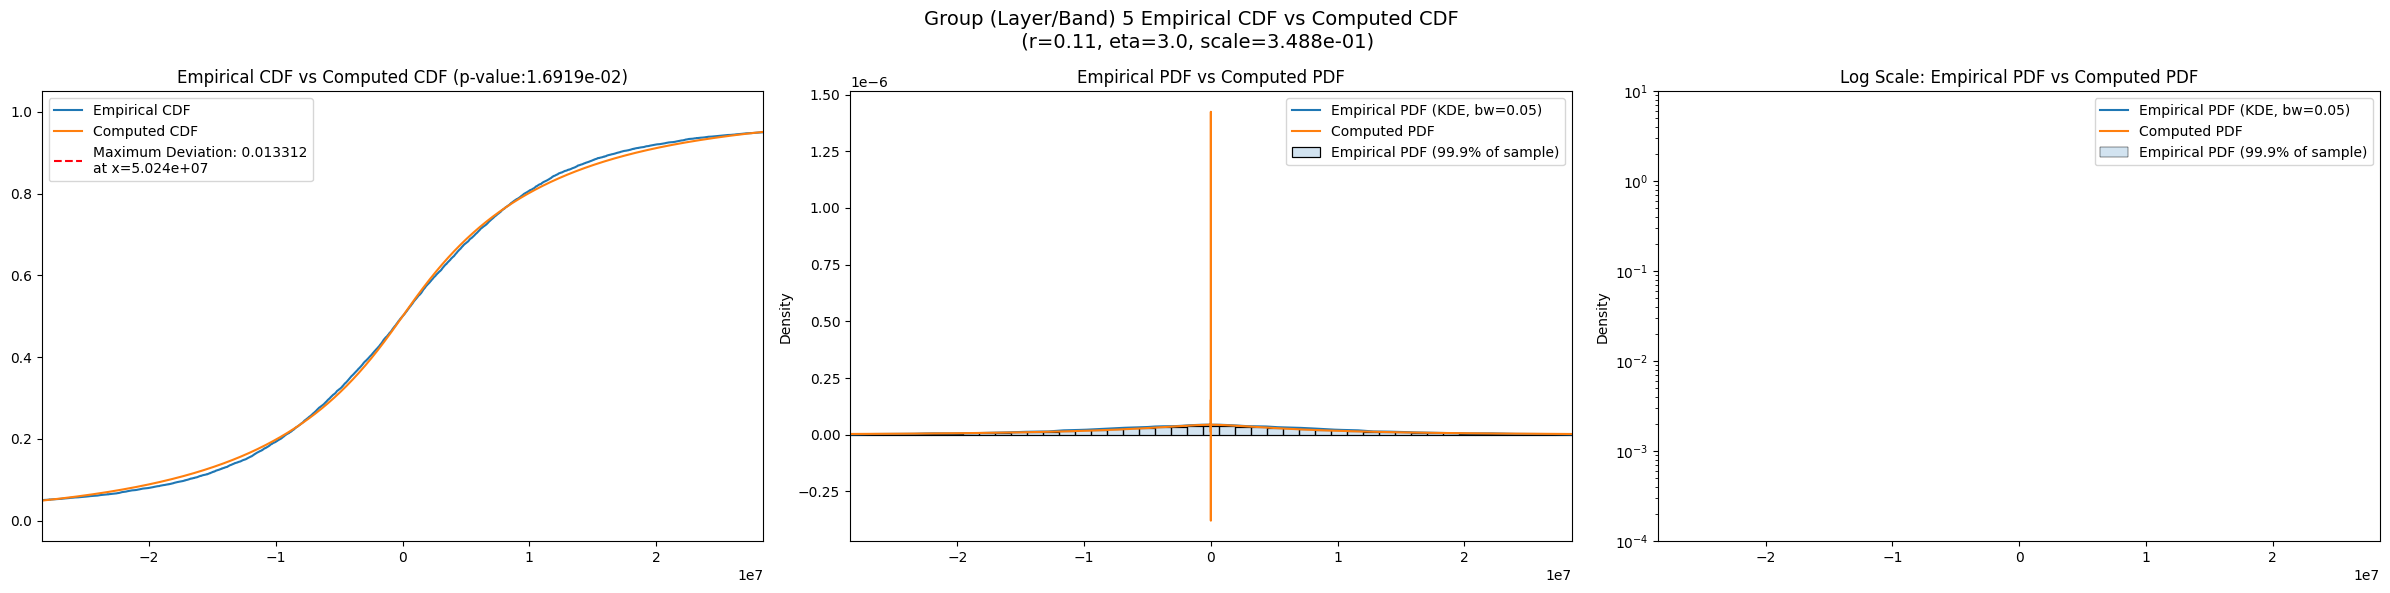

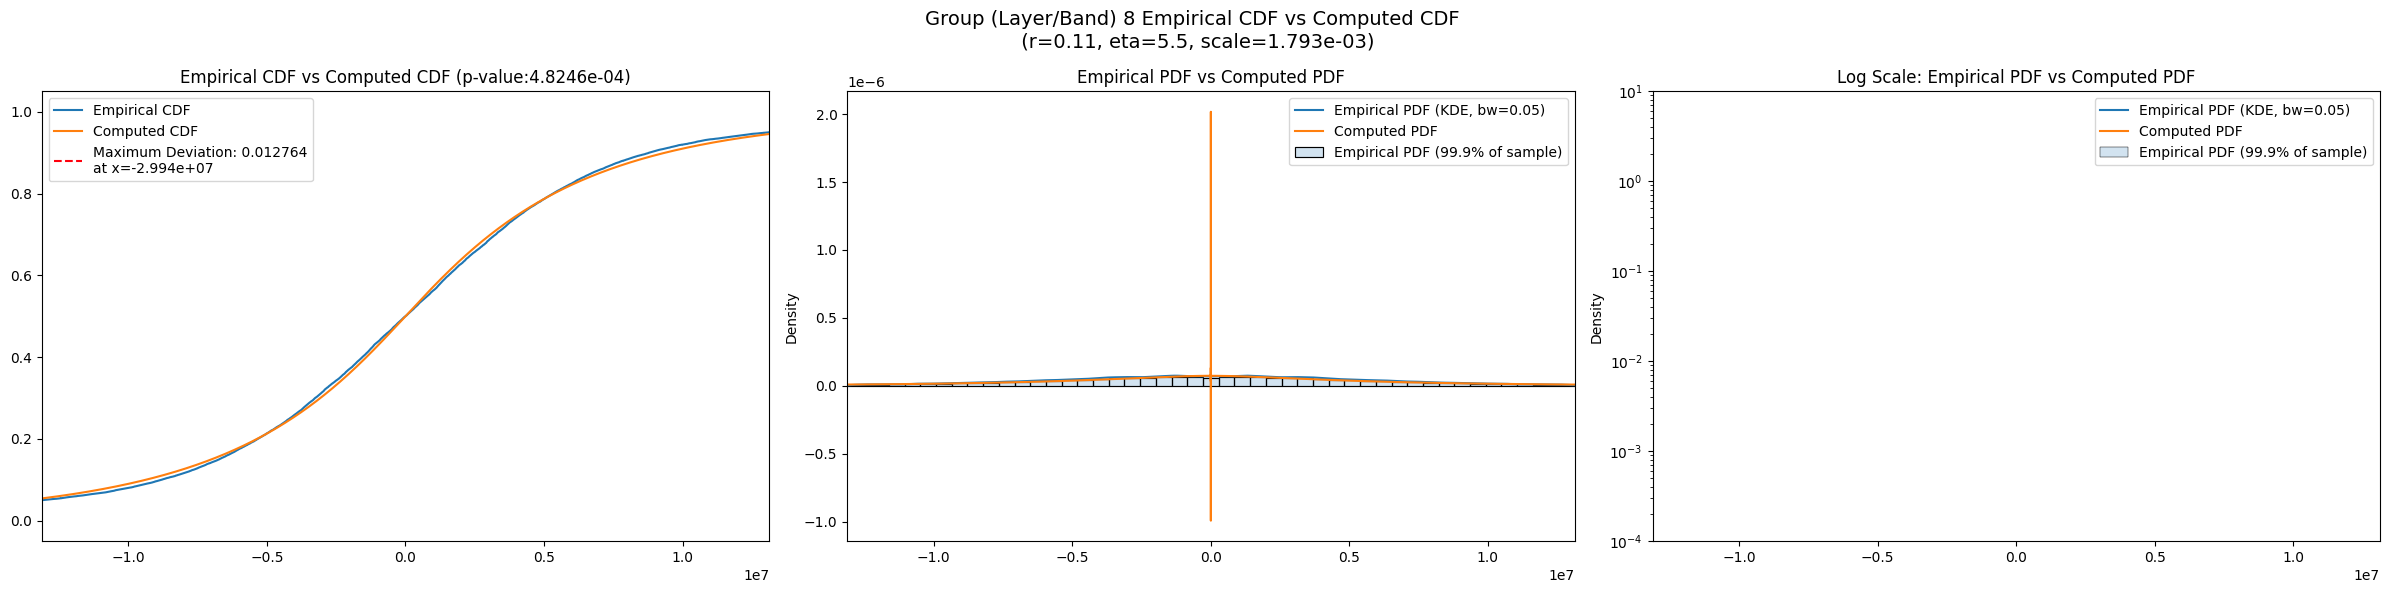

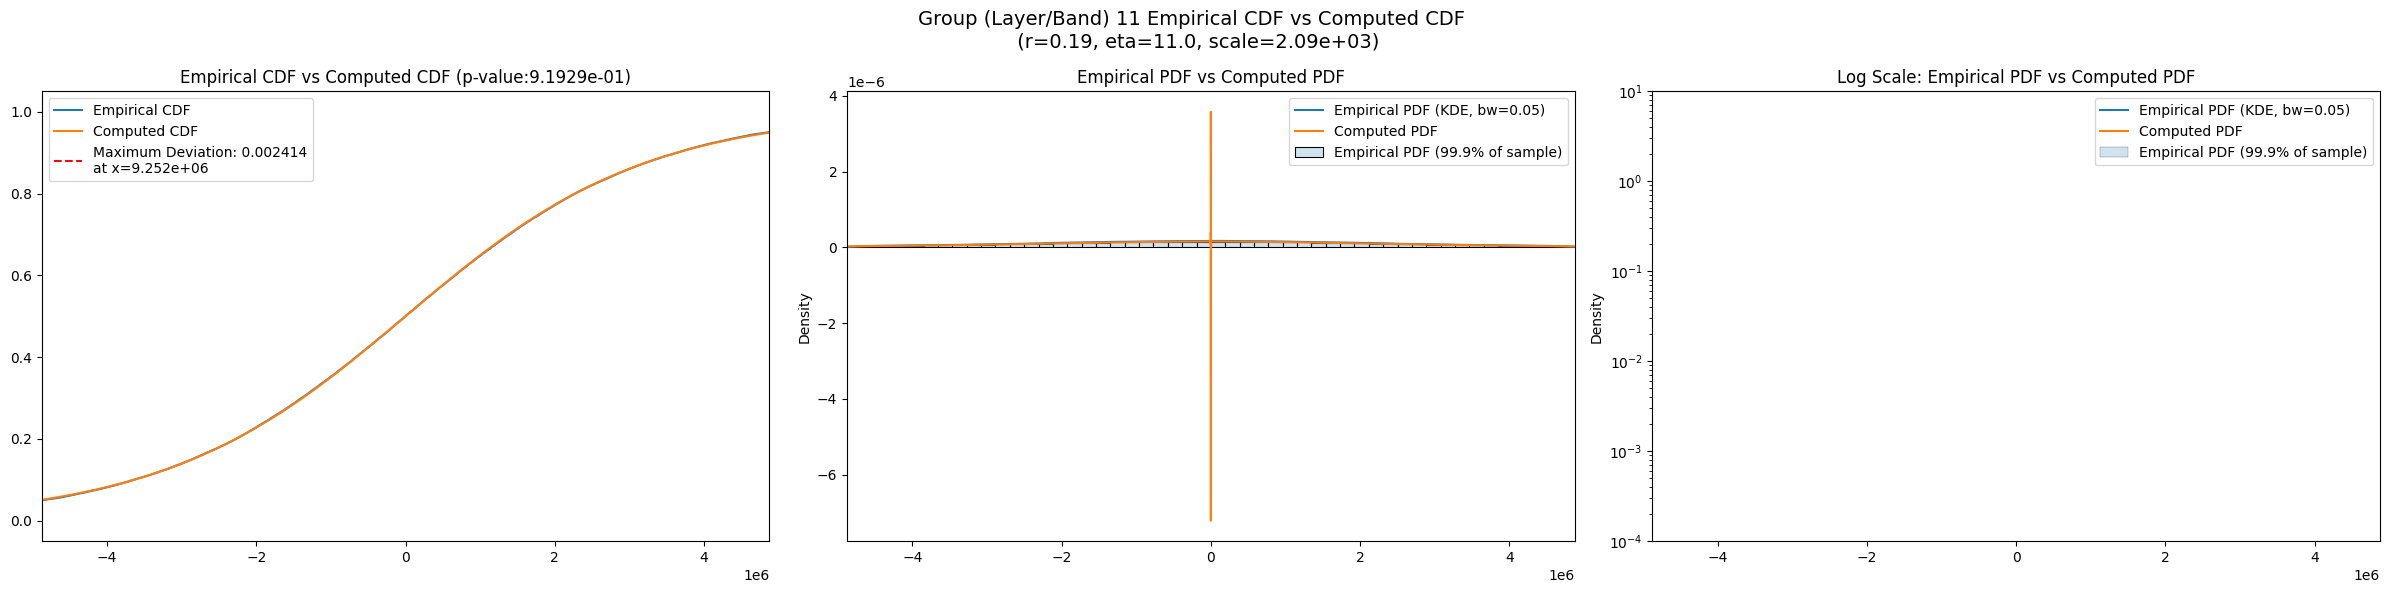

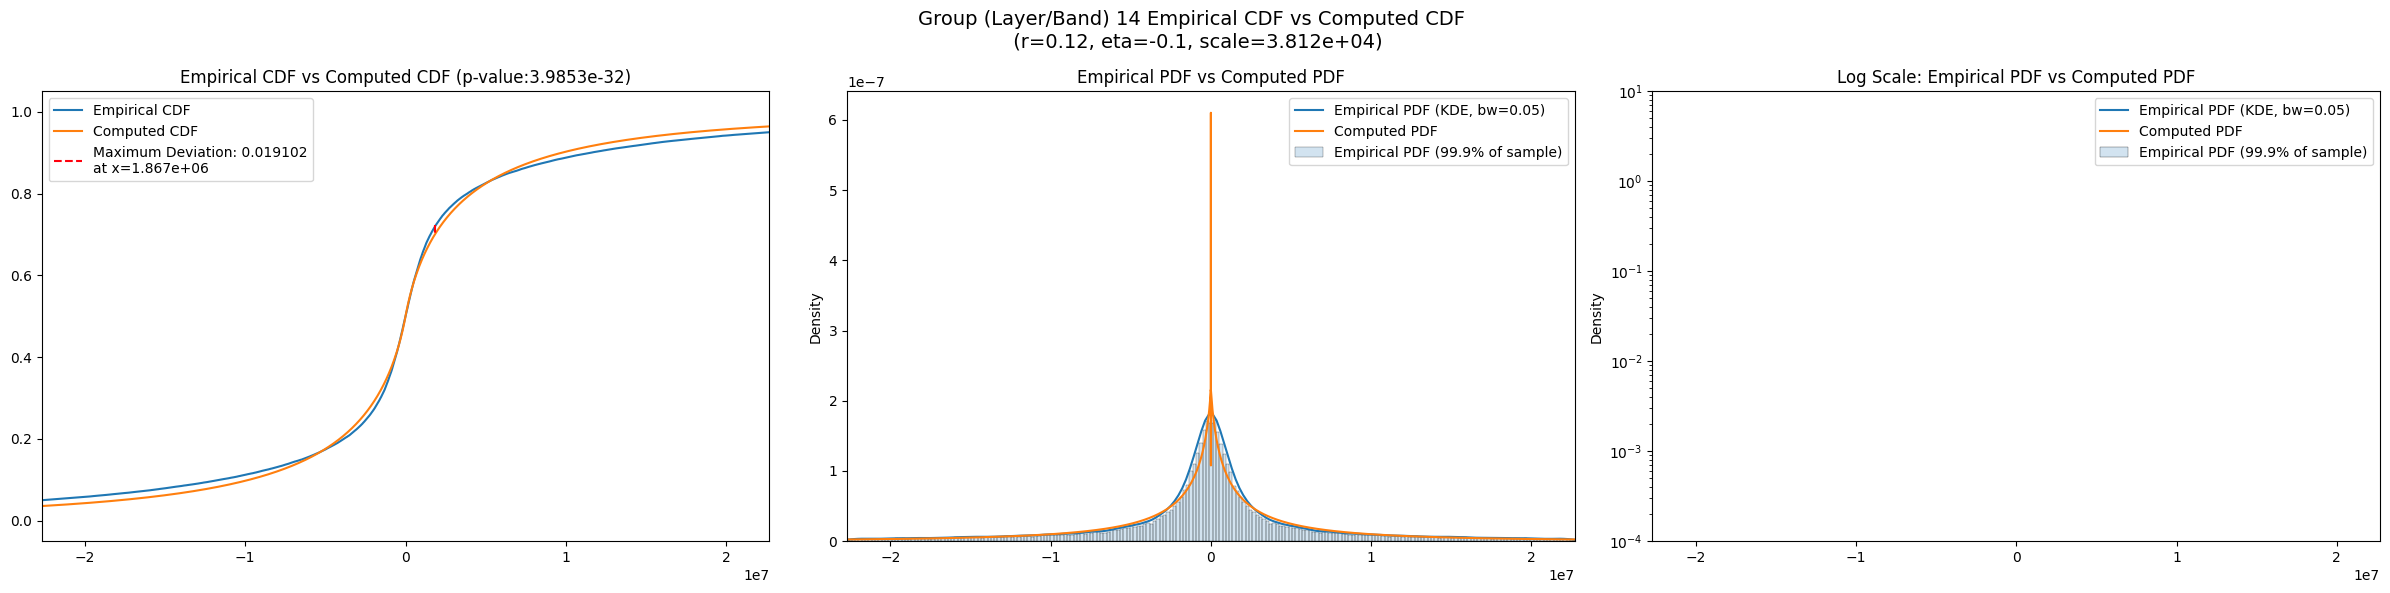

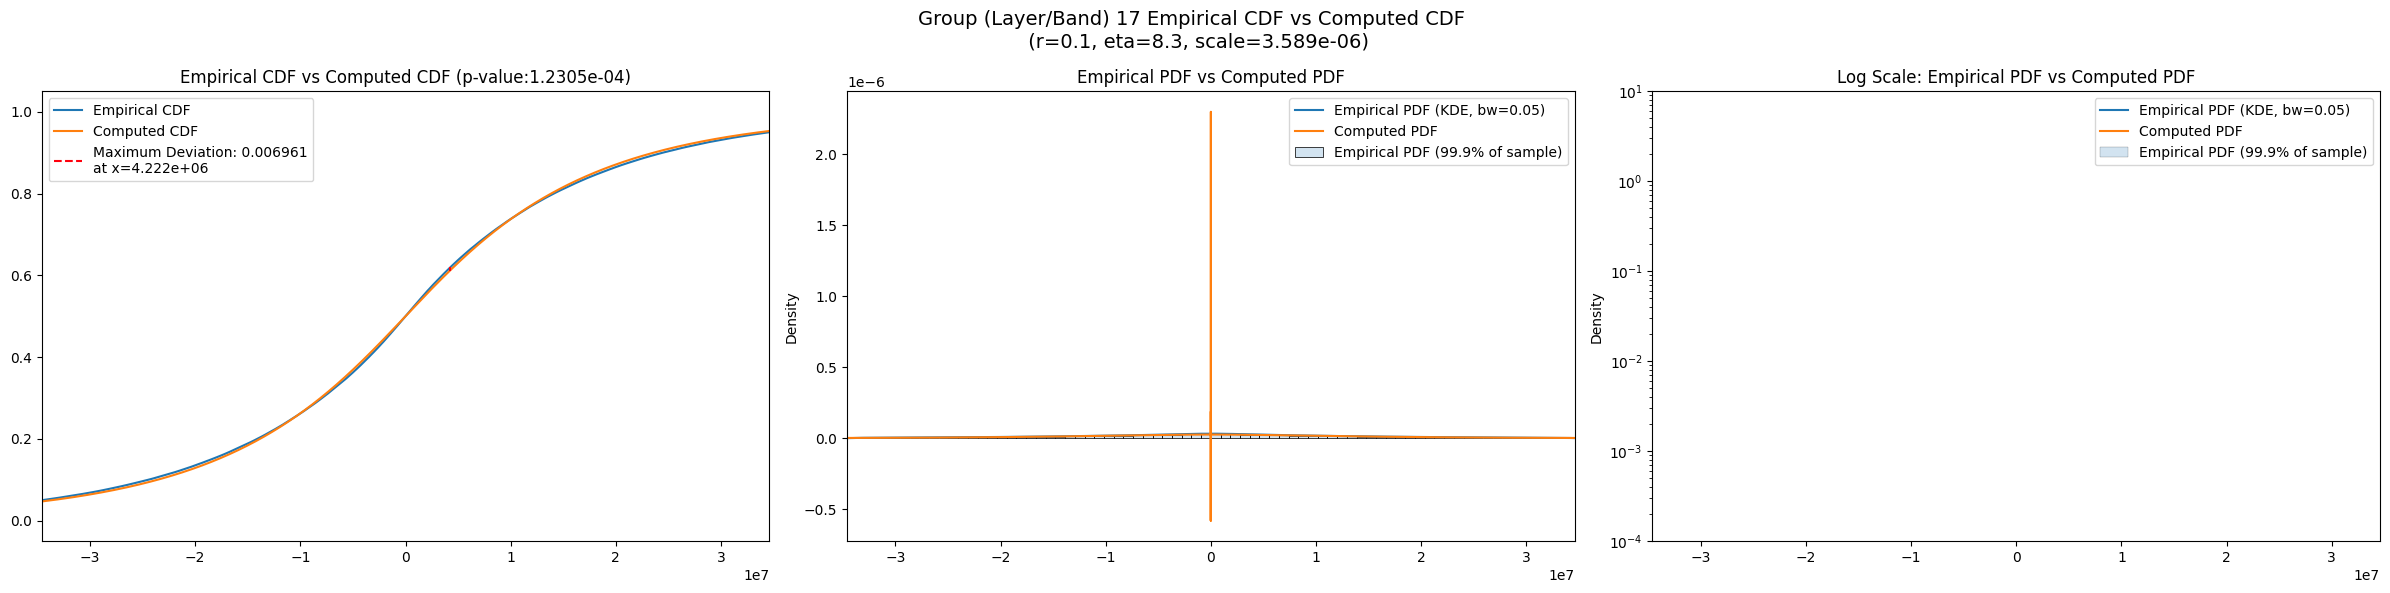

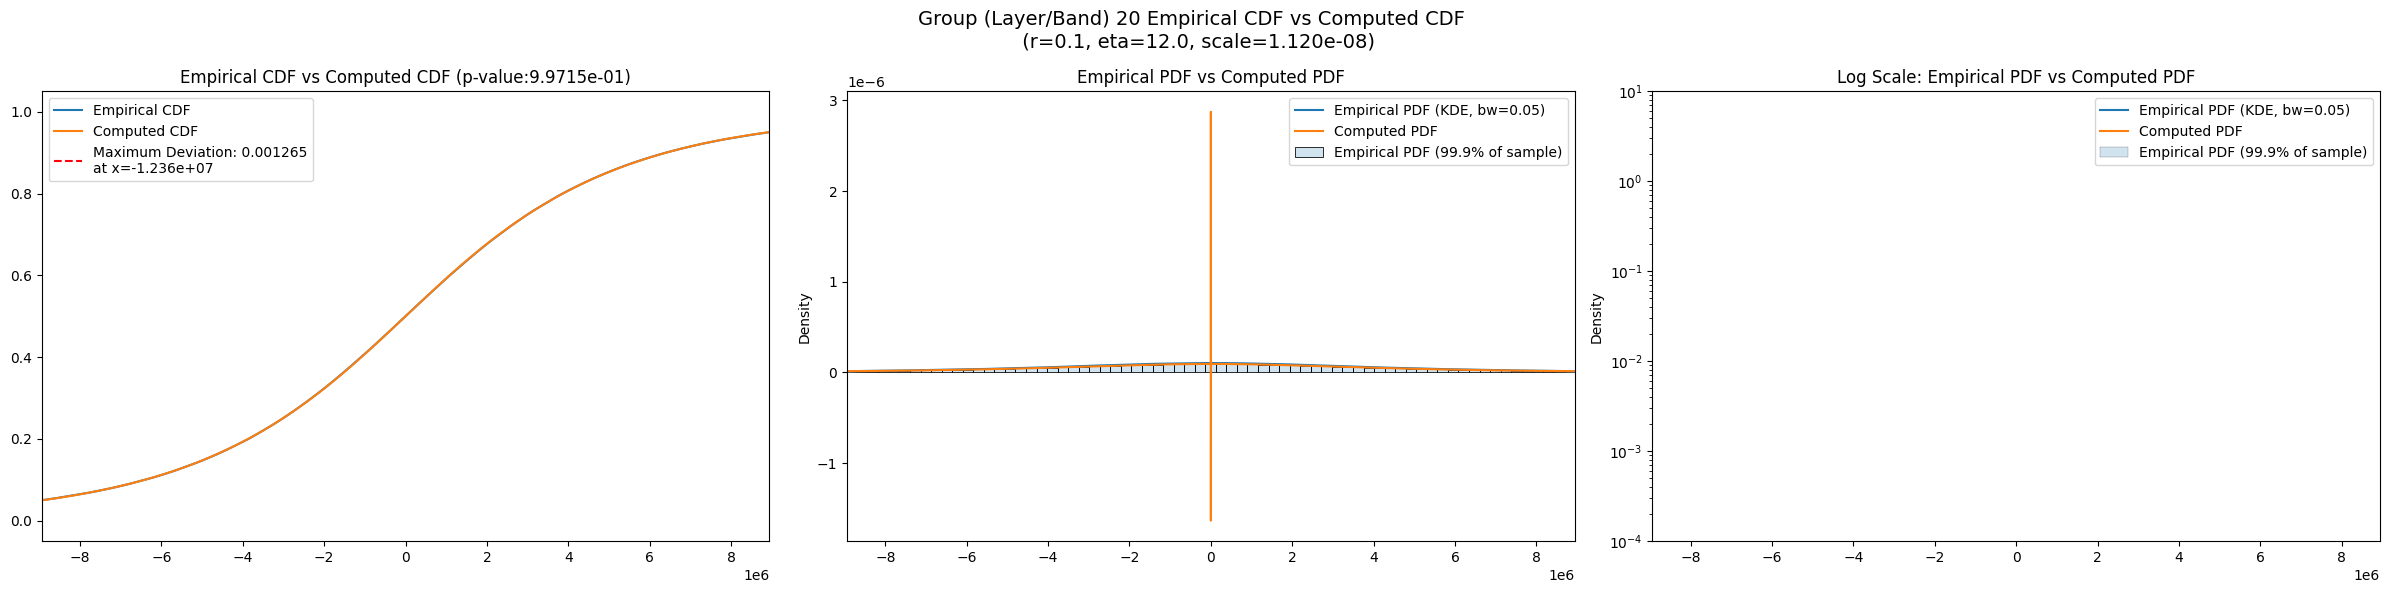

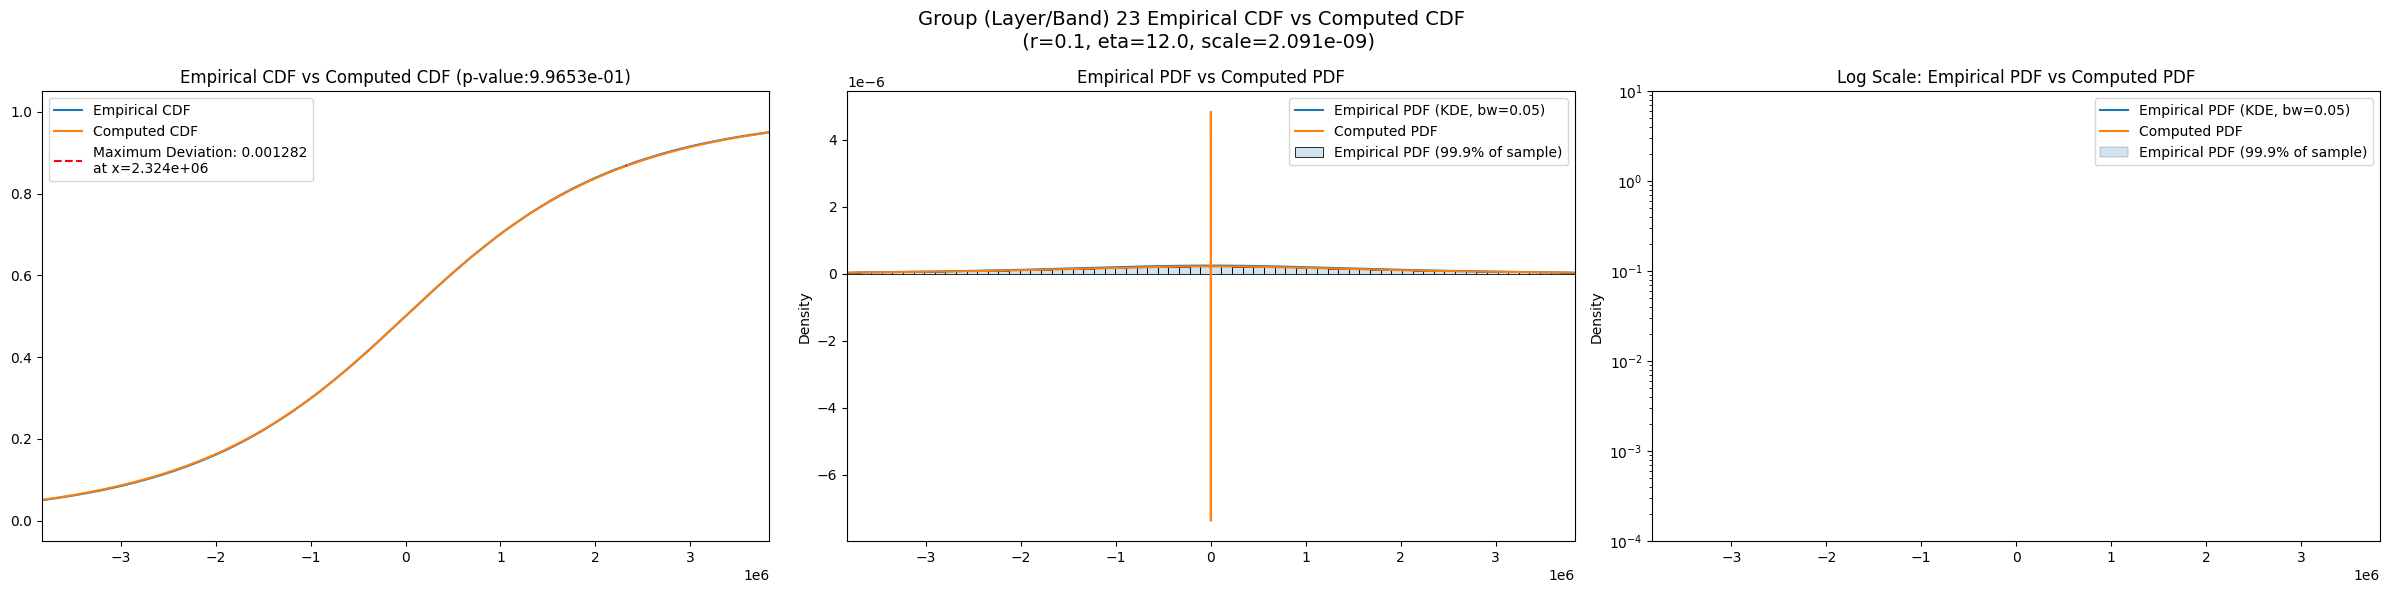

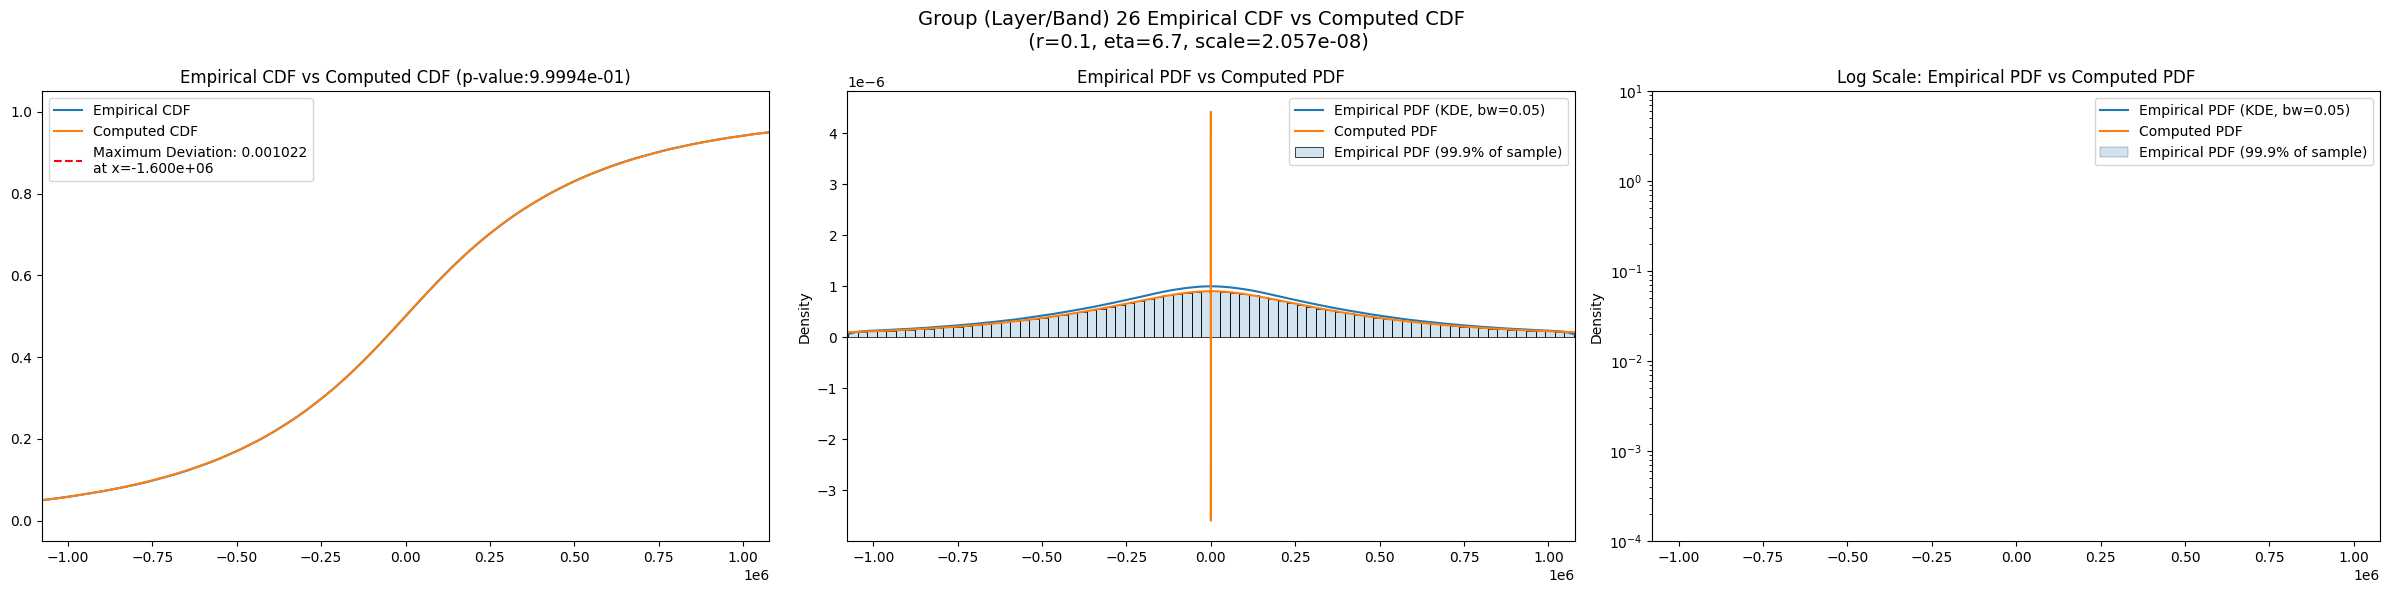

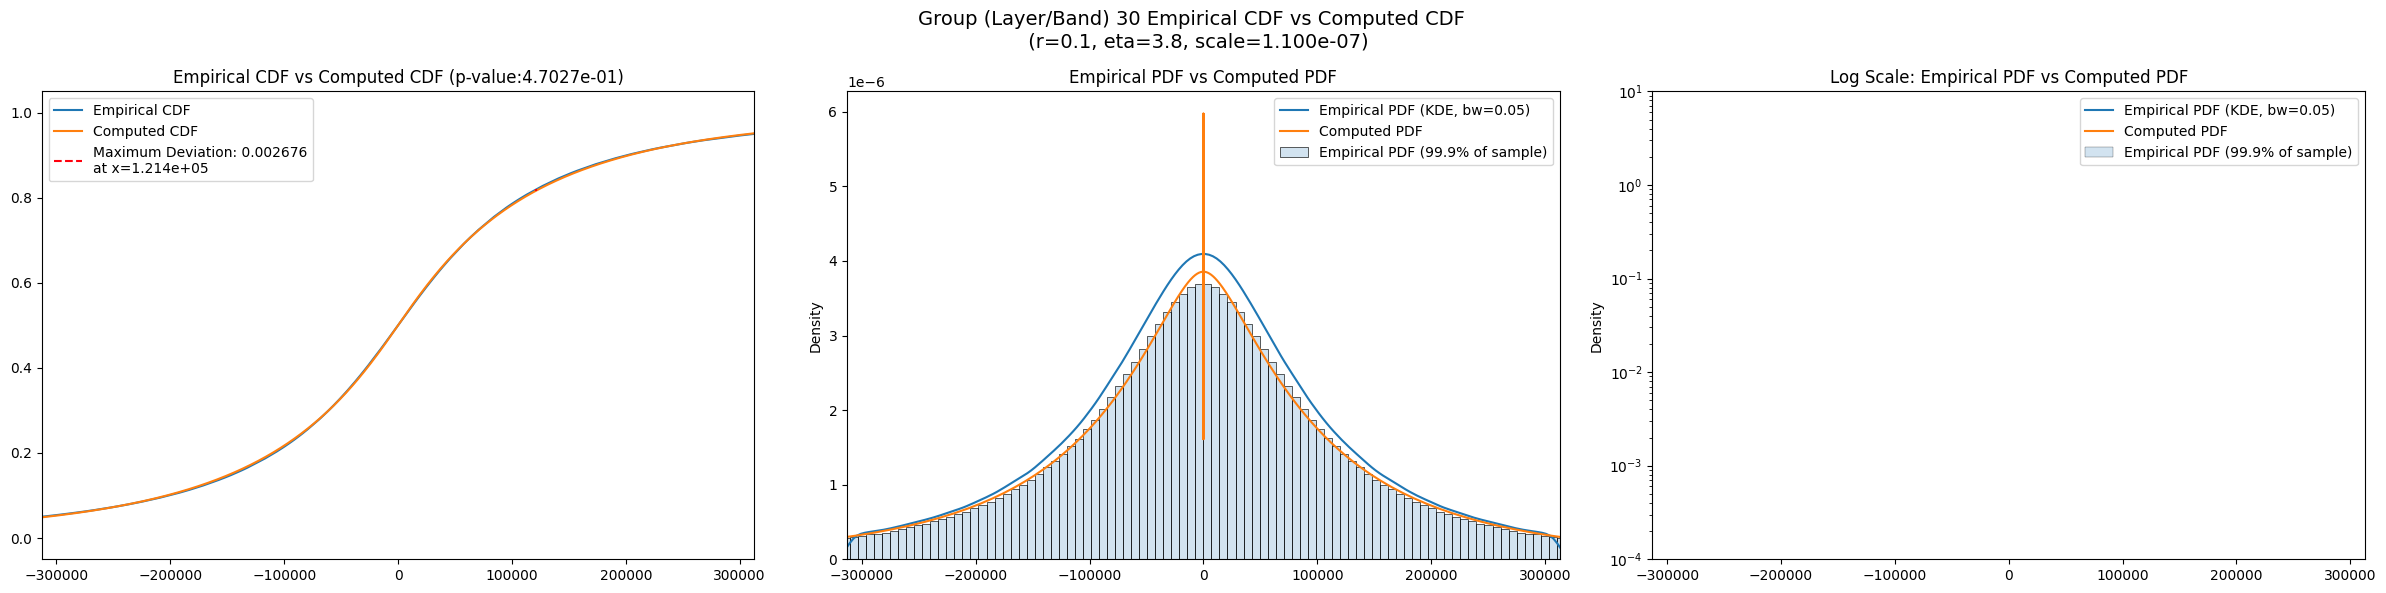

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
band,,,,,,,,,,,,,,,,,,,,,
2,4.046382e+14,3.362530e+14,4.864355e+14,4.984685,1.631070,7.899402,672.0,0.008600,0.1,9.9,...,1000000.0,0.428547,1.395300e-112,1000000.0,0.393615,2.390800e-94,1000000.0,0.370762,2.141610e-83,1.000000e+00
5,7.262077e+14,6.367131e+14,8.205416e+14,22.108093,18.623894,25.663944,6720.0,0.013319,0.1,3.4,...,1000000.0,0.401265,0.000000e+00,1000000.0,0.364207,0.000000e+00,1000000.0,0.340939,0.000000e+00,1.829958e-01
8,1.727584e+14,1.500757e+14,1.981757e+14,27.011762,19.469443,35.718103,12768.0,0.012797,0.1,5.7,...,1000000.0,0.349865,0.000000e+00,1000000.0,0.305635,0.000000e+00,1000000.0,0.281575,0.000000e+00,3.092280e-02
11,1.031208e+13,9.508736e+12,1.135868e+13,9.955516,2.822415,25.242559,26208.0,0.002544,0.2,11.0,...,1000000.0,0.219933,0.000000e+00,1000000.0,0.176248,0.000000e+00,1000000.0,0.151393,0.000000e+00,9.979253e-01
14,2.609331e+14,2.330198e+14,2.917817e+14,17.159369,12.404442,23.441854,52416.0,0.019397,0.1,0.2,...,1000000.0,0.248264,0.000000e+00,1000000.0,0.204903,0.000000e+00,1000000.0,0.181018,0.000000e+00,4.811100e-17
17,4.576780e+14,4.315130e+14,4.857278e+14,3.208279,2.227048,5.537420,420672.0,0.006961,0.1,8.3,...,1000000.0,0.421521,0.000000e+00,1000000.0,0.388206,0.000000e+00,1000000.0,0.365303,0.000000e+00,3.919113e-18
20,3.265137e+13,3.059805e+13,3.499262e+13,4.674552,2.595851,11.092677,841344.0,0.001266,0.1,12.0,...,1000000.0,0.303769,0.000000e+00,1000000.0,0.257017,0.000000e+00,1000000.0,0.232848,0.000000e+00,1.349102e-01
23,6.188053e+12,5.718660e+12,7.074987e+12,14.056033,2.924093,80.213660,6730752.0,0.001282,0.1,12.0,...,1000000.0,0.154797,0.000000e+00,1000000.0,0.115631,0.000000e+00,1000000.0,0.089337,0.000000e+00,4.909310e-10
26,5.004437e+11,4.612222e+11,5.520137e+11,9.796255,4.317054,34.083070,3365376.0,0.001023,0.1,6.7,...,547708.0,0.026064,0.000000e+00,477648.0,0.006154,4.057980e-111,387664.0,0.007885,3.675690e-182,1.755898e-03


## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_best,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t
band,,,,,,
2,0.008600,0.052135,0.008600,0.428547,0.393615,0.370762
5,0.013319,0.016542,0.013312,0.401265,0.364207,0.340939
8,0.012797,0.012006,0.012765,0.349865,0.305635,0.281575
11,0.002544,0.008383,0.002414,0.219933,0.176248,0.151393
14,0.019397,0.005929,0.019102,0.248264,0.204903,0.181018
17,0.006961,0.002094,0.006961,0.421521,0.388206,0.365303
20,0.001266,0.001480,0.001266,0.303769,0.257017,0.232848
23,0.001282,0.000523,0.001282,0.154797,0.115631,0.089337
26,0.001023,0.000740,0.001023,0.026064,0.006154,0.007885


In [ ]:
master_df.filter(regex="best.*")

,best_augmented_var,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff
band,,,,,,
2,4.046382e+14,0.008600,0.10,9.9,7.432927e-07,0.0
5,3.640328e+14,0.013312,0.11,3.0,3.488123e-01,100.0
8,7.783570e+13,0.012765,0.11,5.5,1.792504e-03,225.0
11,9.155396e+12,0.002414,0.19,11.0,2.089778e+03,75.0
14,2.609331e+14,0.019102,0.12,-0.1,3.811502e+04,0.0
17,4.576780e+14,0.006961,0.10,8.3,3.589448e-06,0.0
20,3.120147e+13,0.001266,0.10,12.0,1.120351e-08,50.0
23,5.822539e+12,0.001282,0.10,12.0,2.090698e-09,50.0
26,4.796463e+11,0.001023,0.10,6.7,2.056632e-08,25.0


: 